<a href="https://colab.research.google.com/github/schmcklr/skill_extractor/blob/main/(III)_text_preprocessing_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part III:** Text Preprocessing and Skill Analysis

The present program offers a variety of features designed to track and analyze the progression of desired job qualifications over time. The program should be executed in Google Colab with GPU acceleration enabled. There are three implemented analysis options for this:

1.   Frequency Analysis
2.   LDA Topic Modeling (default: tomotopy LDA model)
3.   Dynamic Topic Modeling (default: gensim LDA Sequence model)


**Note:** Execution of sections 1 to 6 are the default settings. Section 7 provides alternative frameworks for conducting LDA topic modeling (gensim) and DTM (tomotopy, LDA-over-time).



# 1. Load data, applying filters & defining basic functions




1.1 Import of general preprocessed and translated job advertisements ([part 2](https://colab.research.google.com/drive/1EvylGHg4NLHiKnsAmW9l42AQUzLT2c5w#scrollTo=K2XUY2Qk6n7w&uniqifier=2))

* Import data

In [106]:
!pip install --upgrade pandas --quiet
import pandas as pd

#Fetching preprocessed data
workbook = 'https://github.com/schmcklr/skill_extractor/blob/main/job_data/job_data_preprocessed_extracted_qualifications_final.xlsx?raw=true'

# Import of tabs
job_data = pd.read_excel(workbook, sheet_name="Sheet1")

# Convert to lower case
job_data = job_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 28.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.


* Store number of job ads per year before filtering

In [107]:
# Group the DataFrame by year
grouped_before_filtering = job_data.groupby(job_data['created_at'].dt.year)

# Create a dictionary to store the new DataFrames
year_df_before_filtering = {}

# Split groups into separate dataframes and store them in a dictionary
for year, group in grouped_before_filtering:
    year_df_before_filtering[year] = group.copy()

year_df_before_filtering = {year: df for year, df in year_df_before_filtering.items()}

# Number of jobs ads per year before text preprocessing
number_of_ads_per_year_before_filtering = {}
for year in year_df_before_filtering:
  number_of_ads_per_year_before_filtering[year] = len(year_df_before_filtering[year]['qualifications'])

# Total number of job advertisements before filtering
number_of_job_ads_before_filtering = str(len(job_data['description']))

### 1.2 Define Filters for analysis

In [208]:
# Keywords for title filtering
job_keywords_title = ["bpm", "process", "bpmn", "business process management", "bpm", "bpmn", "business process analysis", "process improvement", "process analysis", "business process"]
# Keywords for description filtering
job_keywords_description = [ "bpm", "process improvement", "process analysis", "business process"]

#######################################
# Filter #1: Filter job ads by keywords
#######################################
# Option (1): Filter job titles
#job_data = job_data[job_data['title'].str.contains('|'.join(job_keywords_title), case=False)]
#filter_type = 'title'
# Option (2): Filter job description
job_data = job_data[job_data['description_translated'].str.contains('|'.join(job_keywords_description), case=False)]
filter_type = 'description'

##############################################################
# Filter #2: Filter for specific years (activated by default)
############################################x##################
filter_for_years = True
years = [2015, 2018, 2019, 2020, 2021, 2022]

#################################################################################
# Filter #3: Filter out internships/working student jobs (deactivated by default)
#################################################################################
student_keywords = ["internship", "working student", "intern", "practical"]
#job_data = job_data[~job_data['title'].str.contains('|'.join(student_keywords), case=False)]

###############################################################################################################################
# Setting #1: Frequency Analysis: Generate Filtering Option to filter Tokens by a Predefined List of Skills (activated by default)
###############################################################################################################################
filter_by_skills = True

###################################################################################################################
# Setting #2: Coherence measurement: Can be helpful for detecting the right number of topics (activated by default)
###################################################################################################################
calculate_coherence = False

########################################################################################################################################################
# Setting #3: Alternative models: Choose whether to calculate the alternative models from section 7 (increased execution time) (deactivated by default)
#######################################################################################################################################################
calculate_alternative_models = False

# Extract the year from the 'date_column' and save it in a new column 'year'
job_data['year'] = job_data['created_at'].dt.year

# Filter out duplicates in 'qualifications', keeping only duplicates within the same year
job_data = job_data[~job_data.duplicated(subset=['qualifications', 'year'], keep='first')]

# User info (Number of job advertisements after filtering)
print('Filtering successfull! ' + str(len(job_data['description'])) + '/' + number_of_job_ads_before_filtering + ' Job advertisements are left.')

Filtering successfull! 2336/2840 Job advertisements are left.


### 1.3 Preview of filtered job data




In [109]:
# Displaying job data
import pandas as pd
from IPython.display import display, HTML

# Set pandas display option
pd.set_option('display.max_colwidth', None)

job_data_display = job_data[['title', 'qualifications', 'created_at']].copy()  # create an explicit copy

# Convert 'created_at' column to datetime format to make sure it's in the correct date format
job_data_display['created_at'] = pd.to_datetime(job_data_display['created_at'])

# Extract the year from the 'created_at' column and store it in a new column 'year'
job_data_display['year'] = job_data_display['created_at'].dt.year
job_data_display = job_data_display[['title', 'qualifications', 'year']]

# Get 5 random rows from the DataFrame
job_data_display = job_data_display.sample(5)

# Set text alignment
#job_data_display = job_data_display.style.set_properties(**{'text-align': 'left'}).set_table_styles([
#   dict(selector='th', props=[('text-align', 'left')])
#])

# Display DataFrame with HTML
display(HTML(job_data_display.to_html().replace('\\n','<br>')))

,title,qualifications,year
634,global venture development traineeship,"sales operations, marketing, business technology, logistics, supply chain, business development. willingness to relocate to berlin and to have 3-6 months long missions around the globe international mindset, english fluent (plus: one additional language) 100% dedication, 100% humble, 100% motivation, 100% team-player at least one internship or prior experience at a startup ability to work in a fast-paced startup environment strong leadership and self-motivated people-oriented and target-driven",2019
2604,intern - product management - issuer csd service (f/m/d),"you are enrolled in a bachelor's or master's degree programme with a recognized institution and can provide an internship agreement, or have graduated with a bachelor's degree or similar for no more than 6 months written and oral proficiency in english is mandatory. french and/or german is considered as an advantage. being pro-active and autonomous while being able to meet strict deadlines knowledge of the financial markets, products, and the primary market. proficiency in ms office (excel, powerpoint...). appetency for analytics and figures. proficiency in bloomberg",2022
1029,consumer engagement services (ces) - internship - global it hub,"you have an analytical mind, and at the same time very good communication skills, you are not afraid to talk to important stakeholders and you are able to explain technical details in an easy language you never procrastinate, you transform insights into immediate action points to improve the current solutions landscape or ways of working you have either a business background and interest in technology or a technical background willing to grow soft/ consulting skills experience working in a contact centre for a cpg company is an asset, understanding of business processes within a contact centre you are comfortable working with raw data (advanced skills in excel highly desirable) and curious about power bi capabilities experience or interest in consumer engagement services, and passion for cutting-edge technologies (salesforce, chatbots, ai) passion for agile framework and high level understanding of software delivery process you have excellent presentation skills, you are a master of powerpoint you are self-driven, proactive and attentive to details strong written and oral communications skills is a must fluency in english (written and oral) is a must high interest in salesforce technologies understanding of cloud solutions",2019
2804,working student (m/f/d) quality management system | job id: 19240,"please remember to upload your current certificate of enrolment, the extract from the study regulations regarding the mandatory internship requirements as well as your current transcript of records, as these are essential for processing the application. applicants from severely handicapped people are welcome. ihre vollständigen bewerbungsunterlagen senden sie bitte an: vitescotechnologies gmbh frau magdalena kammermeier stellencode: 19240 arbeitszeit: teilzeit ihr ansprechpartner: magdalena kammermeier 19240_stellenausschreibung.pdf",2022
1810,senior data engineer - business monitoring,"proficiency & expertise in working with apache flink (or a similar real-time stream processing framework) and elasticsearch (or a similar persistence backend or database) start with a ""yes"" attitude for a team which values it's individuals highly, but also is not afraid to ""disagree and commit"". business acumen and strategy knowledge for handling reporting and kpi requests from stakeholders across all business domains keep it simple attitude with the right amount of foresight designing an efficient and flexible architecture",2021


### 1.4 Initialise Lemmatizer

In [110]:
import nltk
import requests
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

# Initialise lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


### 1.5 Defining function for static LDA topic visualization
*   uses pyLDAvis to display gensim LDA topic models

In [111]:
# Downgrade Versions to be compatible with pyldavis (only if there is an error)
#!pip install numpy==1.22
#!pip install pandas==2.0.0

# Needed for topic visualization
!pip install --upgrade pyldavis --quiet
#!pip install pyLDAvis==2.1.2 --quiet
#!pip install --upgrade numpy --quiet
#!pip install --upgrade pandas --quiet


import pyLDAvis
import pyLDAvis.gensim_models
import webbrowser

# Function which allows visualization of topic modeling
def visualization_with_vis(lda_model, corpus, dictionary, name):
  vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds='mmds')
  pyLDAvis.enable_notebook()
  pyLDAvis.display(vis)
  pyLDAvis.save_html(vis, name + '.html')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 63.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.0 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.0 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.0 which is incompatible.


# 2. Create skill list and skill extract function

Only be executed if filter_by_skills is active (deactivated by default):
*   Get skills from API (emsicloud)
*   Import of O*NET technology skills
*   Import od ESCO skills
*   Add list with custom skills
*   Define function for skill extraction

Always be executed:
*   Defining and Replacing skill synonyms









### 2.1 Connecting to Emsicloud (API)




In [112]:
if filter_by_skills:
  # Requesting access token
  url = "https://auth.emsicloud.com/connect/token"
  payload = "client_id=lwtnyxiuohd90aqc&client_secret=ZqV4d9LQ&grant_type=client_credentials&scope=emsi_open"
  headers = {'Content-Type': 'application/x-www-form-urlencoded'}
  response = requests.request("POST", url, data=payload, headers=headers)
  url = "https://emsiservices.com/skills/versions/latest/skills"

  # Storing access token
  access_token = response.json()["access_token"]

  # Requesting skill list
  querystring = {"fields": "name,type,category,subcategory", "limit": "100000"}
  headers = {'Authorization': 'Bearer ' + access_token}
  response = requests.request("GET", url, headers=headers, params=querystring)
  data = response.json()

  # Initialise skill array
  skills = []

  # Initialise skill dict
  skills_dict = {}

  # Add skills to skills_dict
  for entry in data["data"]:

      # Skill name
      if " (" in entry["name"]:
          name = lemmatizer.lemmatize(entry["name"].lower().replace('.','').split("_(")[0])
      else:
          name = lemmatizer.lemmatize(entry["name"].lower().replace('.',''))
      # Skill category
      if entry['category'] is None:
          category = 'other'
      elif entry['category']["name"] == 'NULL':
          category = 'other'
      else:
          category = entry['category']["name"]
      # Skill Subcategory
      if entry['subcategory'] is None:
          subcategory = 'other'
      elif entry['subcategory']["name"] == 'NULL':
          subcategory = 'other'
      else:
          subcategory = entry['subcategory']["name"]
      # Add skill information to skills_dict
      skills_dict[name] = {
          'name': name,
          'category': category,
          'subcategory': subcategory
      }

  # Add skills to array
  for entry in data["data"]:
    if " (" in entry["name"]:
      skill = lemmatizer.lemmatize(entry["name"].lower().replace('.','').split(" (")[0])
    else:
      skill = lemmatizer.lemmatize(entry["name"].lower().replace('.',''))
    skills.append(skill)

  # Store categories & subcategories
  categories = {}
  sub_categories = {}

  for skill in skills_dict.values():
      category = skill['category']
      if category not in categories:
          categories[category] = []
      categories[category].append(skill['name'])

  for skill in skills_dict.values():
      subcategory = skill['subcategory']
      if subcategory not in sub_categories:
          sub_categories[subcategory] = []
      sub_categories[subcategory].append(skill['name'])

  # Store number of EMSI/Lightcast skills
  number_of_skills_lightcast = len(skills)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.2 Import of O*NET technology skills

In [113]:
if filter_by_skills:
  import pandas as pd

  # Import technology skills raw data
  skills_onet_workbook = 'https://github.com/schmcklr/skill_extractor/blob/main/skill_data/skills_onet.xlsx?raw=true'

  # Import of tabs
  skills_onet = pd.read_excel(skills_onet_workbook, sheet_name="Technology Skills")

  # Convert to list
  skills_onet = skills_onet['Example'].str.lower().tolist()

  # Append to skill list
  skills += skills_onet

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.3 Import of ESCO skills

In [114]:
if filter_by_skills:
  !pip install odfpy --quiet
  import pandas as pd

  # Import ESCO skills raw data
  skills_esco_workbook = 'https://github.com/schmcklr/skill_extractor/blob/main/skill_data/skills_esco.ods?raw=true'

  # Import of tabs
  skills_esco = pd.read_excel(skills_esco_workbook, sheet_name="Skills")

  # Convert to list
  skills_esco = skills_esco['preferredLabel'].str.lower().tolist()

  # Append to skill list
  skills += skills_esco

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### 2.4 Extend list with custom skills

*   Creating own skill list
*   Replace blanks in compound skills with '_' to recognise them as one token
*   Definition of the skills defined in the Gartner Skillset
*   Convert to set remove duplicates and get faster access




In [115]:
if filter_by_skills:
  from re import U
  # Creating own skill list
  other_skills = ['python', 'c++', 'c', 'r', 'java', 'hadoop', 'scala', 'flask', 'pandas', 'spark', 'scikit-learn',
                  'numpy', 'php', 'sql', 'mysql', 'css', 'mongdb', 'nltk', 'fastai', 'keras', 'pytorch', 'tensorflow',
                  'ruby', 'javascript', 'django', 'react', 'reactjs', 'ai', 'ui', 'tableau', 'crm', 'modeling',
                  'bpm', 'vision', 'communication', 'analysis', 'design', 'excel', 'itil', 'data',
                  'governance', 'police', 'simulation', 'automation', 'kpi', 'erp', 'statistic', 'sap', 'german',
                  'english', 'kafka', 'api', 'rest', 'database', 'metrics', 'autonomy', ]

  # Creating composed skills (needed for lemmatization that words considered as one word)
  composite_skills = ['process_modeling', 'application_development', 'change_techniques', 'business_case',
                      'business_process_improvement', 'business_process', 'team_player', 'web_development',
                      'quality_management']

  # Custom list for BPM Gartner skill set
  gartner_skill_set = ['business_case', 'business_process', 'project_management', 'organizational', 'communication',
                      'change_management', 'process_discovery', 'process_mod', 'extract_data', 'data_visualization',
                      'architecture', 'bpmn', 'bpm', 'agile_development', 'optimization', 'user_experience', 'ui','process_management'
                      ]

  # Extending skill list fetched from Emsi and O*NET
  skills += other_skills
  skills += composite_skills
  skills += gartner_skill_set

  # Replace the blanks with '_' to recognise compound skills
  for i in range(len(skills)):
    skills[i] = skills[i].replace(" ", "_")

  # Convert to set remove duplicates and get faster access
  skills = set(skills)

  # Number of unique skill terms
  #print('Number of EMSI/Lightcast skills: ' + str(number_of_skills_lightcast))
  #print('Number of O*NET skills: ' + str(len(set(skills_onet))))
  #print('Number of ESCO skills: ' + str(len(set(skills_esco))))
  print('Number of unique skills: ' + str(len(skills)))

Number of unique skills: 54663


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.5 Create list with skill synonyms


In [116]:
skill_synonyms = {
    'artificial_intelligence' : ['ai', 'artifical_intelligence'],
    'user_interface': ['ui'],
    'business_process_management': ['bpmn', 'bpm'],
    #'english_language': ['english', 'fluent_english'],
    'german_language': ['german'],
    'microsoft_excel': ['excel', 'especially_excel'],
    'crm': ['customer_relationship_management'],
    'business_intelligence': ['bi'],
    'sap_fi': ['fi'],
    'sap_hana': ['hana'],
    'powerpoint': ['power_point'],
    'bachelor_degree': ['bachelor'],
    'master_degree': ['master'],
    #'communication_skill': ['communication', 'strong_communication', 'communicate', 'communication_strength', 'communicative'],
    #'analytical_skill': ['analytical'],
    'automation': ['automation_anywhere'],
    'team_player': ['teamplayer'],
    'power_bi': ['powerbi'],
}

skill_synonyms_frequency_analysis = {
    'artificial_intelligence' : ['ai', 'artifical_intelligence'],
    'user_interface': ['ui'],
    'business_process_management': ['bpmn', 'bpm'],
    'english_language': ['english', 'fluent_english', 'englisch'],
    'german_language': ['german'],
    'microsoft_excel': ['excel', 'especially_excel'],
    'crm': ['customer_relationship_management'],
    'business_intelligence': ['bi'],
    'sap_fi': ['fi'],
    'sap_hana': ['hana'],
    'powerpoint': ['power_point'],
    'bachelor_degree': ['bachelor'],
    'master_degree': ['master'],
    'communication': ['communication_skill', 'strong_communication', 'communicate', 'communication_strength', 'communicative'],
    'analytical_skill': ['analytical'],
    'automation': ['automation_anywhere'],
    'team_player': ['team', 'teamwork', 'teamplayer'],
    'power_bi': ['powerbi'],
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.6 Function for replacing skill synonyms

In [117]:
# Function for replacing synonym skills
def replace_synonym_skills(filtered_docs, skill_synonyms):
    for doc in filtered_docs:
        for i in range(len(doc)):
            for key in skill_synonyms.keys():
                if doc[i] in skill_synonyms[key]:
                    doc[i] = key
                    break
    return filtered_docs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 3. Text preprocessing


*  Define stopwords and stopwords removal function  
*  Define function for special character removing
*  Split job dataframe by year
*  Text Preprossesing
*  Compute bigrams, trigrams with gensim phraser
*  Define and revert phrases to be ignored during n-gram generation


### 3.1 Define stopwords and removal functions  





*   3.1.1 Defining stopword list


In [118]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# English stopwords
english_stopwords = stopwords.words('english')

# German stopwords
german_stopwords = stopwords.words('german')

# Custom stopwords list (will be removed after N-gram generation)
custom_stop_words = ['genetics','go', 'public', 'transport', 'pregnancy','cash', 'le', 'register', 'make', 'm', 'nice', 'work', 'b',
                    'client', 'skill', 'good', 'allianz', 'celonis', 'internship', 'opportunity', 'robotics', 'billing', 'talent'
                    'chemistry', 'disability',  'working', 'offer', 'product', 'requirement', 'und', 'toyota', '1st', 'paris',
                    'investment', 'consulting', 'banking', 'merchandising', 'stock', 'amazon', 'are', 'amadeus', 'oe', 'must', 'celonis', 'are',
                    'automotive', 'safe', 'best', 'privacy', 'well', 'work', 'strong', 'commercial', 'dealer', 'you', 'none', 'entry', 'level',
                    'br', 'kpmg', 'complex', 'ability', 'experience', 'first', 'high', 'relevant', 'system', 'excellent',
                    'use', 'personal', 'knowledge', 'understanding', 'plus', '#', 'br_br', 'e_g', 'ideally', 'amazon_equal'
                    'able', 'year', 'school', 'scor', 'required', 'new', 'position', 'bull', 'br', 'already', 'gained', 'looking',
                    'already_gained', 'would', 'win', 'field', 'br_bull', 'e', 'de', 'etc', '#_#', 'within', 'company', 'background', 'ee',
                    'great', 'et', 'month', 'candidate', 'enviroment', 'uf0b7', 'fluent', 'need', 'ä',
                    'n', 'free', 'part', 'point', 'car', 'like', 'would_plus', 'understand', 'want', 'last', 'g', 'alytics', '+2',
                    'month_full', 'using', 'f', 'availability', 'http_www', 'closely', 'mercedes-benz', 'sixt', 'need_choose', '++',
                    'area', 'customer', 'industry', 'able', 'equivalent', 'including', 'related', 'stakeholder', 'proven', 'preferably',
                    'oriented', 'change', 'time', 'interest', 'preferred', 'similar', 'role', 'basic', 'focus', 'expertise', 'advantage',
                    'drive', 'know', 'hand', 'multiple', 'gap_year', 'way_working', 'full', 'medium', 'office', 'tool', 'structured',
                    'comparable', 'least', 'pronounced', 'bring', 'year_professional', 'chemistry', 'lufthansa', '+49', 'yes','degree','end',
                    'solution', 'previous', 'drive_celonis', 'celonis','unicredit', 'bank','application', 'sale',
                    'business','management', #'process'
                    ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


*   3.1.2 Defining functions for stopword removal


In [119]:
import re

# Function for removing stopwords from dataframe
def remove_stopwords(doc):
  filtered_doc = []
  filtered_doc = [token for token in doc if token not in english_stopwords and token not in german_stopwords]
  return filtered_doc

# Function for removing custom stopwords from dataframe
def remove_custom_stopwords(doc):
  filtered_doc = []
  filtered_doc = [token for token in doc if token not in custom_stop_words]
  return filtered_doc

# Function for removing tokens that only contain numbers
def remove_numeric_tokens(tokens):
    return [token for token in tokens if not bool(re.match(r'^[0-9]+$', token))]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3.2 Function for url and special character removing




* Function for url removal

In [120]:
def remove_links(text):
    # Define a regular expression pattern to detect URLs
    url_pattern = r'https?://\S+|www\.\S+'

    # Replace URLs in the text with spaces
    text_without_links = re.sub(url_pattern, ' ', text)

    return text_without_links

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* Function for special character removing

In [121]:
import re

# List of exceptions (combinations that should not be removed)
exceptions = ['c++', 'c#']

# Function to remove special characters while considering exceptions for individual tokens
def remove_special_characters(tokens):
    # Create a regular expression to remove special characters
    special_characters_pattern = r'[^\w\s]'

    # Create a regular expression for exceptions
    exceptions_pattern = '|'.join(re.escape(exception) for exception in exceptions)

    # Initialize a list to store the cleaned tokens
    cleaned_tokens = []

    for token in tokens:
        # Combine the two regular expressions and remove special characters,
        # but keep the exceptions unchanged
        cleaned_token = re.sub(f'({exceptions_pattern})|(?:{special_characters_pattern})', r'\1', token)
        cleaned_tokens.append(cleaned_token)

    return cleaned_tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3.3 Split job dataframe by year

In [122]:
# Group the DataFrame by year
grouped = job_data.groupby(job_data['created_at'].dt.year)

# Create a dictionary to store the new DataFrames
year_dfs = {}

# Split groups into separate dataframes and store them in a dictionary
for year, group in grouped:
    year_dfs[year] = group.copy()

# Filter by years
if filter_for_years:
  year_dfs = {year: df for year, df in year_dfs.items() if year in years}

# Number of jobs ads per year before text preprocessing
number_of_ads_per_year = {}
for year in year_dfs:
  number_of_ads_per_year[year] = len(year_dfs[year]['qualifications'])

# User Info (Number of job ads per year)
print(number_of_ads_per_year)

{2015: 95, 2018: 190, 2019: 499, 2020: 618, 2021: 677, 2022: 189}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3.4 Text Preprossesing
*   Remove URLs
*   Tokenize documents
*   Remove numbers, but not words that contain numbers
*   Remove stopwords
*   Lemmatization


In [123]:
!pip install spacy --quiet
nltk.download('omw-1.4');
nltk.download('wordnet');
nltk.download('punkt');
import spacy
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

# Create list whith all documents for tasks like computing bigrams/trigrams
docs_all = []
filtered_docs_all = []
docs_by_year = {}
docs_by_year_frequency_analysis = {}
filtered_docs_all_frequency_analysis = []
new_doc_complete_all = []
filtered_docs_all_corpus = []

# Preprossesing based on year
for year in year_dfs:

  docs = list(year_dfs[year]['qualifications'])

  # Remove URLs from text
  docs = [remove_links(doc) for doc in docs]

  # Tokenize the documents
  tokenizer = RegexpTokenizer(r'[\w#+]+')
  for idx in range(len(docs)):
      docs[idx] = docs[idx].lower()  # Convert to lowercase
      docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words

  # Remove numbers, but not words that contain numbers
  docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

  # Remove words that are only one character
  docs = [[token for token in doc if len(token) > 1 or token in ['r', 'c']] for doc in docs]

  # Innizialise lemmatizer
  lemmatizer = WordNetLemmatizer()

  # Lemmatize the documents
  docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

  # Remove stopwords
  docs = [remove_stopwords(doc) for doc in docs]

  # Remove special characters
  docs = [remove_special_characters(doc) for doc in docs]

  # Add processed docs to docs_by_year dict
  docs_by_year[year] = docs

  # Add processed docs to docs_all list (used for overall lda model and bigram/trigram calculation)
  docs_all += docs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### 3.5 Compute bigrams, trigrams with gensim phraser

In [124]:
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser

# Compute bigrams
bigram = Phrases(docs_all, min_count=12)#, threshold=6)
# Compute trigrams
trigram = Phrases(docs_all, min_count=12)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* Define phrases to be ignored and function to revert unwanted phrases




In [125]:
# Define word pairs to be ignored within the phrases creation
ignored_phrases = ['german_english', 'example_sentence', 'bachelor_master', 'verbal_written', 'written_spoken', 'english_german', 'spoken_written',
'written_verbal', 'oral_written', 'word_excel', 'fluency_english', 'dutch_french', 'python_r', 'excel_powerpoint', 'economics_mathematics',
'end_end', 'french_dutch', 'advanced_excel', 'lean_six', 'excel_word', 'powerpoint_excel', 'javascript_html', 'mathematics_comparable',
'mathematics_statitic', 'html5_cs', 'automation_anywhere', 'write_english', 'english_fluently']

# Revert unwanted phrases back into individual words in the document
def revert_unwanted_phrases(doc, ignored_phrases):
  for phrase in doc:
    if '_' in phrase and phrase in ignored_phrases:
        word1, word2 = phrase.split('_')
        index = doc.index(phrase)  # Index of the original trigram
        doc.remove(phrase)  # Remove the original trigram
        doc.insert(index, word1)  # Insert the first word at the original position
        doc.insert(index + 1, word2)  # Insert the second word right after
  return doc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3.6 Token Filtering
*   Creating bigrams/trigrams
*   There are options for token filterung for Frequency Analyses:
  *   Use all words, except stopwords (default)
*   replace synonym skills
*   remove custom stopwords
*   remove empty docs



In [126]:
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

# Preprossesing based on year
for year in docs_by_year:

  # Load docs for year
  docs = docs_by_year[year]

  # Creating bigrams/trigrams, filter out phrases that should be ignored
  for idx in range(len(docs)):
      # Creating bigrams/trigrams calculated by gensim phraser
      docs[idx] = trigram[bigram[docs[idx]]]
      # Filter out phrases that should be ignored
      docs[idx] = revert_unwanted_phrases(docs[idx], ignored_phrases)

  # Store filtered docs
  filtered_docs = []

  # Filter docs
  for doc in docs:
      # Define tokens
      tokens = doc

      # Use all words, except custom stopwords (default)
      new_tokens = [token for token in tokens]

      # POS-Filtering (default: Exclude Verbs)
      #tagged_tokens = pos_tag(new_tokens)
      # Filter and keep all words except verbs
      #new_tokens = [token for token, tag in tagged_tokens if not tag.startswith('VB')]

      # Filter and keep all words except verbs and adjectives
      #new_tokens = [token for token, tag in tagged_tokens if not tag.startswith('VB') and not tag.startswith('JJ')]

      # Convert list of tokens into a string and add it to the new list of documents
      filtered_docs.append(new_tokens)


  # Replace synonym skills basic (used for topic modeling)
  filtered_docs = replace_synonym_skills(filtered_docs, skill_synonyms)

  # Remove Custom Stopwords
  filtered_docs = [remove_custom_stopwords(doc) for doc in filtered_docs]

  # Remove empty docs and docs with less than 200 characters
  filtered_docs = [doc for doc in filtered_docs if doc and len(" ".join(doc).replace("_", "")) >= 200]

  # Store filtered docs by year
  docs_by_year[year] = filtered_docs

  # Store filtered docs for the entire period
  filtered_docs_all += filtered_docs


# Store filtered docs for frequency analysis
docs_by_year_frequency_analysis = docs_by_year

# Replace synonym skills advanced (used for frequency analysis)
for year, docs in docs_by_year_frequency_analysis.items():
  docs_by_year_frequency_analysis_replace_synonym_skills = replace_synonym_skills(docs, skill_synonyms_frequency_analysis)
  docs_by_year_frequency_analysis[year] = docs_by_year_frequency_analysis_replace_synonym_skills
  filtered_docs_all_frequency_analysis += docs_by_year_frequency_analysis_replace_synonym_skills

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### 3.7 Document statistics
* number of documents
* tokens per document
* characters per document

* Number of job postings per year

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1000x500 with 0 Axes>

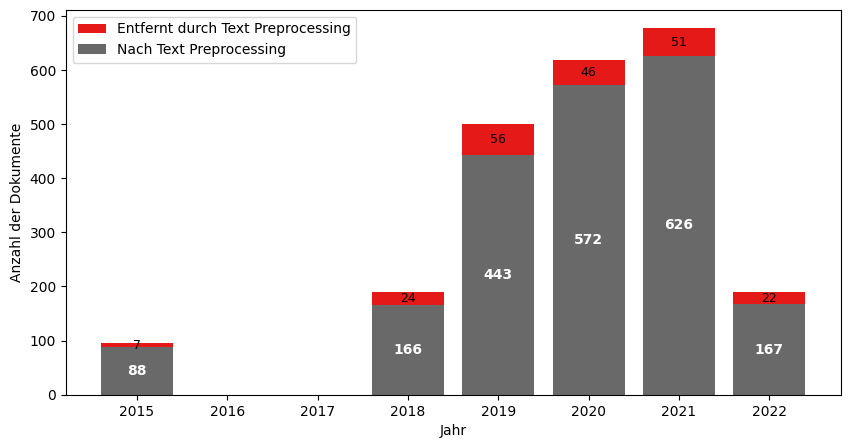

In [127]:
import matplotlib.pyplot as plt

# Number of jobs ads per year after text preprocessing
number_of_ads_per_year_after_prepro = {}
for year in docs_by_year:
  number_of_ads_per_year_after_prepro[year] = len(docs_by_year[year])

# Set colors
color = '#696969'
color2 = '#e61919'#plt.cm.get_cmap('Reds')(0.4)  # Adjust the saturation here (0.5 means 50% saturation)
#color2 = sns.color_palette("husl", 1)

# Sort the data by years
sorted_data = sorted(number_of_ads_per_year_after_prepro.items())
sorted_data_before_prepro = sorted(number_of_ads_per_year.items())


# Creating a figure object
fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots(figsize=(10,5))


# Creating bar plot with jobs ads per year before text preprocessing
years_before_prepro = [x[0] for x in sorted_data_before_prepro]
counts_before_prepro = [x[1] for x in sorted_data_before_prepro]
bars_before_prepro = ax.bar(years_before_prepro, counts_before_prepro, color=color2, label='Entfernt durch Text Preprocessing')

# Creating bar plot with jobs ads per year after text preprocessing
years = [x[0] for x in sorted_data]
counts = [x[1] for x in sorted_data]
bars = ax.bar(years, counts, color=color,label='Nach Text Preprocessing')

# Set lable for number of postings
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height/2, int(height),
            ha='center', va='center', color='white', fontweight='bold', fontsize=10)


# Set lable for number of postings before preprocessing
for i, bar in enumerate(bars_before_prepro):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., counts[i] + (height - counts[i])/2, (str(int(height - counts[i]))),
            ha='center', va='center', color='black', fontsize=9)


# Set axis, labels, legend and title
ax.set_xlabel('Jahr', fontsize=10)
ax.set_ylabel('Anzahl der Dokumente', fontsize=10)
ax.legend()
#plt.title("Number of job postings by year", fontsize=16)

# Display chart
plt.show()

* Tokens per document

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1000x500 with 0 Axes>

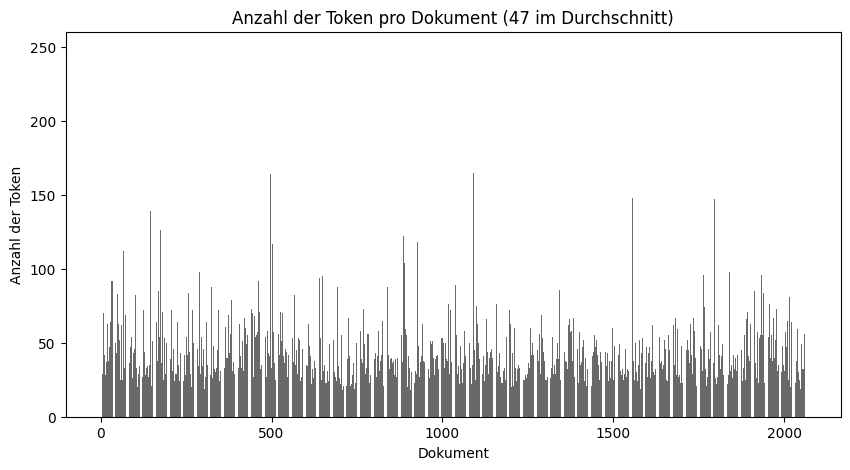

In [128]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
fig = plt.figure(figsize=(10, 5))

# Create subplots within the figure with a specific size
fig, ax = plt.subplots(figsize=(10, 5))

# Determine the number of tokens per document
token_counts = [len(doc) for doc in filtered_docs_all]

# Create an index for the x-axis
x = range(1, len(filtered_docs_all) + 1)

# Calculate the token mean
mean = sum(token_counts) / len(token_counts)

# Create the chart and define labels
plt.bar(x, token_counts,color=color)
plt.xlabel('Dokument')
plt.ylabel('Anzahl der Token')
plt.title('Anzahl der Token pro Dokument (' + f"{mean:.0f} im Durchschnitt)")
plt.show()

*  Characters per document

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


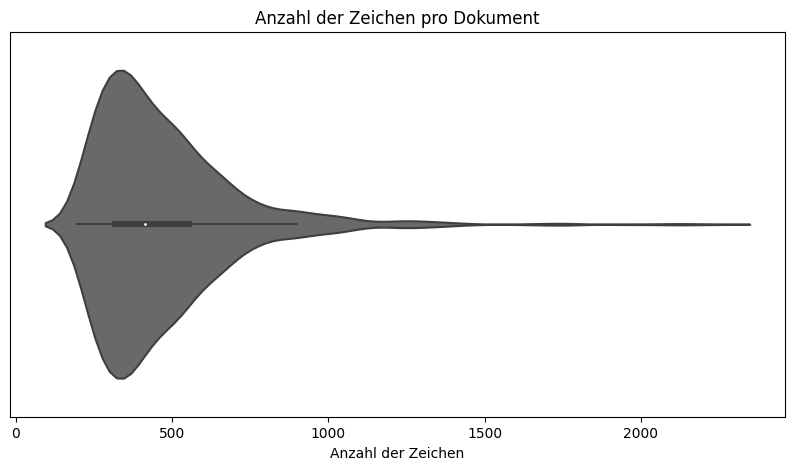

Min: 196
Max: 2247
Median: 413.0
Durchschnitt: 472


In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

# Zeichenanzahl pro Dokument (ohne Unterstrich "_")
char_counts = [len(" ".join(doc).replace("_", "")) for doc in filtered_docs_all]

# Erstellen Sie den horizontalen Violinplot
plt.figure(figsize=(10, 5))
sns.violinplot(x=char_counts, color=color, orient="h")

#plt.ylabel('Dokument')
plt.yticks([])
plt.xlabel('Anzahl der Zeichen')
plt.title('Anzahl der Zeichen pro Dokument')

plt.show()

# Berechnen Sie Min, Max, Median und Durchschnitt
min_value = min(char_counts)
max_value = max(char_counts)
median_value = statistics.median(char_counts)
mean_value = statistics.mean(char_counts)

# Ausgabe der Werte als Text unter dem Plot
print(f'Min: {min_value}')
print(f'Max: {max_value}')
print(f'Median: {median_value}')
print(f'Durchschnitt: {mean_value:.0f}')

# 4. Frequency Analysis


*  Word Cloud: A visual representation of the most frequent words
*  Interactive Chart for Frequency Analysis: Interactively filtering and examining data


### 4.1 Wordcloud representation for each year

In [130]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
from ipywidgets import interact, widgets
import seaborn as sns
import matplotlib.colors as mcolors

# Define colors
color_list = [
    '#B5B5B5', '#999999', '#7F7F7F', '#5C5C5C', '#080808',
    '#030303', '#828282', '#9B9B9B', '#B4B4B4', '#575757'
]

# Alternative colors
#color_list = sns.color_palette("mako", len(docs_by_year))
#color_list = [mcolors.rgb2hex(color) for color in color_list]


color_index = 0

# Generate next color
def generate_next_color():
    global color_index
    if color_index >= len(color_list):
        raise ValueError("All colors have been used.")

    next_color = color_list[color_index]
    color_index += 1
    return next_color

# Generate color mapping for each year
colors = {year: generate_next_color() for year in docs_by_year_frequency_analysis.keys()}

# Generate wordcloud
def generate_wordcloud(year):
    docs_list = docs_by_year_frequency_analysis[year]
    docs = [word for sublist in docs_list for word in sublist]
    text = ' '.join(docs)

    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          min_font_size=5,
                          colormap='viridis',  # You can choose a different colormap here
                          color_func=lambda *args, **kwargs: colors[year]).generate(text)  # Color customization

    # Display the wordcloud
    plt.figure(figsize=(10, 4), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    #plt.title(f"Wordcloud for Year {year}", color=colors[year], fontsize=20)
    plt.show()

# Interactive slider function
interact(generate_wordcloud, year=widgets.Dropdown(options=docs_by_year.keys()));

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


interactive(children=(Dropdown(description='year', options=(2015, 2018, 2019, 2020, 2021, 2022), value=2015), …

In [131]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
from ipywidgets import interact, widgets
import seaborn as sns
import matplotlib.colors as mcolors

# Define colors
color_list = [
    '#B5B5B5', '#999999', '#7F7F7F', '#5C5C5C', '#080808',
    '#030303', '#828282', '#9B9B9B', '#B4B4B4', '#575757'
]

# Alternative colors
#color_list = sns.color_palette("mako", len(docs_by_year))
#color_list = [mcolors.rgb2hex(color) for color in color_list]


color_index = 0

# Generate next color
def generate_next_color():
    global color_index
    if color_index >= len(color_list):
        raise ValueError("All colors have been used.")

    next_color = color_list[color_index]
    color_index += 1
    return next_color

# Generate color mapping for each year
colors = {year: generate_next_color() for year in docs_by_year_frequency_analysis.keys()}

def generate_wordcloud(year):
    docs_list = docs_by_year_frequency_analysis[year]
    docs = [word for sublist in docs_list for word in sublist]
    text = ' '.join(docs)

    # Erstellen Sie eine Liste der Wörter, die im aktuellen Jahr gegenüber dem Vorjahr stark an Bedeutung gewonnen haben
    if year > min(docs_by_year_frequency_analysis.keys()):
        prev_year = year - 1
        current_year_words = set(docs_by_year_frequency_analysis[year])
        prev_year_words = set(docs_by_year_frequency_analysis[prev_year])
        gained_words = list(current_year_words - prev_year_words)
    else:
        gained_words = []

    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        if word in gained_words:
            return "red"  # Wenn das Wort im aktuellen Jahr an Bedeutung gewonnen hat, wird es rot
        else:
            return colors[year]  # Andernfalls verwenden Sie die vordefinierte Farbe für das Jahr

    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          min_font_size=5,
                          colormap='viridis',
                          color_func=color_func).generate(text)

    plt.figure(figsize=(10, 4), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
# Interactive slider function
interact(generate_wordcloud, year=widgets.Dropdown(options=docs_by_year.keys()));

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


interactive(children=(Dropdown(description='year', options=(2015, 2018, 2019, 2020, 2021, 2022), value=2015), …

### 4.2 Interactive Chart for Frequency Analysis


*   Calculates token frequencies for the whole corpus (token is counted once per document)




In [132]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel


# Create dictionary representation of the documents
dictionary = Dictionary(filtered_docs_all_frequency_analysis)
# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in filtered_docs_all_frequency_analysis]

# Extract the frequency of each token from the corpus
token_frequencies = {}
for doc in corpus:
    tokens_in_doc = set()
    for token_id, freq in doc:
        token = dictionary[token_id]
        if token not in tokens_in_doc:
            tokens_in_doc.add(token)
            if token in token_frequencies:
                token_frequencies[token] += 1
            else:
                token_frequencies[token] = 1

# Sort the tokens by descending frequency
token_freqs_overall = []
token_freqs_overall = sorted(token_frequencies.items(), key=lambda x: x[1], reverse=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* Calculates token frequencies for each year (token is counted once per document)

In [133]:
import warnings
from gensim.models import LdaModel
from gensim.models.phrases import Phrases

# Ignore warning caused by gensim library, improve readability
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Store token frequencies for each year
token_freqs = {}

# Analysis based on year
for year in docs_by_year_frequency_analysis:

  docs = docs_by_year_frequency_analysis[year]

  # Create a dictionary representation of the documents
  dictionary = Dictionary(docs)

  # Bag-of-words representation of the documents
  corpus = [dictionary.doc2bow(doc) for doc in docs]

  # Extract the frequency of each token from the corpus (only counted once per doc)
  token_frequencies = {}
  for doc in corpus:
      tokens_in_doc = []
      tokens_in_doc = set()
      for token_id, freq in doc:
          token = dictionary[token_id]
          if token not in tokens_in_doc:
              tokens_in_doc.add(token)
              if token in token_frequencies:
                  token_frequencies[token] += 1
              else:
                  token_frequencies[token] = 1


  # Sort the tokens by descending frequency
  sorted_tokens = []
  sorted_tokens = sorted(token_frequencies.items(), key=lambda x: x[1], reverse=True)
  token_freqs[year] = sorted_tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* Determining the percentage of advertisements that mentioned skills

In [134]:
# Create list to store all extracted skills
most_mentioned_skills = []
for token, freq in token_freqs_overall:
  most_mentioned_skills.append(token)

# Create dict to store the calculated value by year (in which percentage of advertisements is the skill required)
most_mentioned_skills_per_year = {}

# Calculate percentage for each skill in each year
for skill in most_mentioned_skills:
  for year in token_freqs:
    value = 0
    for term, count in token_freqs[year]:
      if skill == term:
        value = count/number_of_ads_per_year_after_prepro[year]
        break
    if skill in most_mentioned_skills_per_year:
      most_mentioned_skills_per_year[skill].append(value)
    else:
      most_mentioned_skills_per_year[skill] = []
      most_mentioned_skills_per_year[skill].append(value)

##### Visualisation the development of tokens over time (Frequency Analysis)

  *   Shows the percentage of documents per year in which a token appears
  *   Filtering can be applied using a list of predefined skills
  *   Search can be used to search for a specific skill

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

# X-axis
years = np.array(list(token_freqs.keys()))

# Create a dropdown list to select token
skills_list = list(most_mentioned_skills_per_year.keys())
skills_checkboxes = widgets.SelectMultiple(
    options=skills_list,
    value=[skills_list[0]],  # Default value for initial selection
    rows=6,
    description='Token:',
    disabled=False,
    layout=widgets.Layout(height='100px')
)

# Create filtering skills list
filtered_skill_list = skills_list

# Create a button to apply the filter
filter_for_skills_button = widgets.Button(description="Filter for Skills")
unfilter_for_skills_button = widgets.Button(description="All Token")

# Create a function to update the skills list based on the filter
def update_skills_list_filter(button_click):
    selected_skills = [skill for skill in skills_list if skill in skills]
    skills_checkboxes.options = selected_skills
    skills_checkboxes.value = [selected_skills[0]]
    skills_checkboxes.description = 'Skills:'
    filtered_skill_list = selected_skills
    # Reset search
    search_text.value = ""

# Create a function to unfilter skills list
def update_skills_list_unfilter(button_click):
    selected_skills = [skill for skill in skills_list]
    skills_checkboxes.options = selected_skills
    skills_checkboxes.value = [selected_skills[0]]
    skills_checkboxes.description = 'Token:'
    filtered_skill_list = selected_skills
    # Reset search
    search_text.value = ""


# Link the button click to the function to update the skills list
filter_for_skills_button.on_click(update_skills_list_filter)
unfilter_for_skills_button.on_click(update_skills_list_unfilter)

# Create a text input field for searching
search_text = widgets.Text(
    placeholder='Search',
    description='Search:',
    disabled=False
)

# Create a function to update the skills list based on the search input
def update_skills_list_search(change):
    search_value = change.new.lower()  # Get the lowercase search input
    filtered_skills = [skill for skill in filtered_skill_list if search_value in skill.lower()]
    skills_checkboxes.options = filtered_skills
    if filtered_skills:
      skills_checkboxes.value = [filtered_skills[0]]

# Link the text input to the search function
search_text.observe(update_skills_list_search, names='value')

# Create a function to plot the selected skills
def plot_skills(skills):
    plt.clf()  # Clear the old plot

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

    for skill in skills:
        skill_data = np.array(most_mentioned_skills_per_year[skill])
        ax.plot(years, skill_data, label=skill)

        # Add the percentage as a label for each data point
        for i, data_point in enumerate(skill_data):
            ax.text(years[i], data_point, f"{data_point:.1%}", ha='center', va='bottom', fontsize=10)

    # Set the x-axis ticks to correspond to the year values
    ax.set_xticks(years)

    # Label the axes
    ax.set_xlabel("Jahr")
    ax.set_ylabel("Anteil an Stellenanzeigen (in Prozent)")

    # Add legend and show plot
    ax.legend()
    plt.show()

# Create an interactive widget to link the function and the checkboxes
interactive_plot = widgets.interactive(plot_skills, skills=skills_checkboxes)

# Create an HBox to display the buttons side by side
button_box = widgets.HBox([unfilter_for_skills_button, filter_for_skills_button, search_text])

# Display the widget and buttons
if filter_by_skills:
  display(button_box)
else:
  display(search_text)
display(interactive_plot)

interactive(children=(SelectMultiple(description='Token:', index=(0,), layout=Layout(height='100px'), options=…

# 5. LDA Topic Modeling


* default: tomotopy LDA model, gensim implementation can be found in section 7





### 5.1 Setting Model parameters

In [136]:
import numpy as np

# Set training parameters
num_topics = 7 # Specifies the number of topics to be extracted from the corpus
min_cf = 10 # minimum collection frequency of words, words with a smaller collection frequency are excluded
min_df = 10 # minimum document frequency of words, words with a smaller document frequency are excluded
rm_top = 2 # the number of top words to be removed

# Number of keywords per topic to display
num_keywords = 20

# Setting the seed to ensure the reproducibility of the results
seed = 22
np.random.seed(seed)

### 5.2 LDA Topic Modeling (tomotopy)

In [137]:
!pip install tomotopy
import tomotopy as tp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.5 MB/s eta 0:00:00


#### 5.2.1 Setting up model

* Use pretrained model (optional)

In [138]:
import os
from ipywidgets import interact, widgets

# Define the directory where the repository folder will be downloaded
download_path = '/content/repository_folder/'

# Specify the URL of the GitHub repository
repository_url = 'https://github.com/schmcklr/skill_extractor.git'

# Download the repository
os.system(f'git clone {repository_url} {download_path}')

# Select trained LDA models
lda_models_pretrained = [file for file in os.listdir('/content/repository_folder/trained_models') if "tomotopy_lda" in file.lower()]

# Dropdown widget
dropdown_lda = widgets.Dropdown(
    options=lda_models_pretrained,
    description='Select trained LDA-Model:',
    disabled=False,
    layout={'width': '800px'},
    style={'description_width': 'auto'}
)

# Add default option
additional_option = ""
dropdown_lda.options = [additional_option] + list(dropdown_lda.options)

# Display dropdown
display(dropdown_lda)

Dropdown(description='Select trained LDA-Model:', layout=Layout(width='800px'), options=('', 'filtered_by_desc…

* Train new model (default)

In [139]:
# Train new model
if dropdown_lda.value == "":
  # Convert the list of lists into a list of strings
  list_of_strings = [' '.join(doc) for doc in filtered_docs_all]

  corpus = []
  # Creating corpus instance
  corpus = tp.utils.Corpus(tokenizer=tp.utils.SimpleTokenizer())

  # Processing list of strings into correct format
  corpus.process(list_of_strings)

  # Create an LDA model and train it
  mdl = tp.LDAModel(k=num_topics, # Specifies the number of topics to be extracted from the corpus
                    min_cf=min_cf, # minimum collection frequency of words, words with a smaller collection frequency are excluded
                    min_df=min_df, # minimum document frequency of words, words with a smaller document frequency are excluded
                    corpus=corpus, # list of documents
                    seed=seed, # random seed
                    rm_top=rm_top # the number of top words to be removed
                    )

  # Train model
  mdl.train(2000)

  # Printing model summary (developing context only)
  #print('Number of documents:', len(mdl.docs), ', Vocabulary size:', len(mdl.used_vocabs), ', Number of words:', mdl.num_words)
  #print('Removed top words:', mdl.removed_top_words)
  #mdl.summary()

# Use pretrained model
else:
  mdl = tp.LDAModel.load('/content/repository_folder/trained_models/' + dropdown_lda.value)

<ipython-input-139-60b1a35ec7d9>:23: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  mdl.train(2000)


* Monitoring training process (disabled by default)   




In [140]:
'''
for i in range(0, 1000, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))
'''

"\nfor i in range(0, 1000, 10):\n    mdl.train(10)\n    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))\n"

* Automated Topic Labeling (disabled by default)

In [141]:
'''
# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=10, min_df=5, max_len=5, max_cand=10000)
cands = extractor.extract(mdl)

# ranking the candidates of labels for a specific topic
labeler = tp.label.FoRelevance(mdl, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(mdl.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=2)))
    for word, prob in mdl.get_topic_words(k, top_n=20):
        print(word, prob, sep='\t')
    print()
'''

'\n# extract candidates for auto topic labeling\nextractor = tp.label.PMIExtractor(min_cf=10, min_df=5, max_len=5, max_cand=10000)\ncands = extractor.extract(mdl)\n\n# ranking the candidates of labels for a specific topic\nlabeler = tp.label.FoRelevance(mdl, cands, min_df=5, smoothing=1e-2, mu=0.25)\nfor k in range(mdl.k):\n    print("== Topic #{} ==".format(k))\n    print("Labels:", \', \'.join(label for label, score in labeler.get_topic_labels(k, top_n=2)))\n    for word, prob in mdl.get_topic_words(k, top_n=20):\n        print(word, prob, sep=\'\t\')\n    print()\n'

* Printing topic words

In [176]:
# Extract top words for each topic
top_words_by_topic = []
for k in range(mdl.k):
    topic_words = [word for word, prob in mdl.get_topic_words(k, top_n=num_keywords)]
    top_words_by_topic.append(topic_words)


# Output the top words for each topic
for k, topic_words in enumerate(top_words_by_topic):
    print("== Topic #{} ==".format(k))
    print(', '.join(topic_words))
    print()

== Topic #0 ==
team_player, project, relationship, partner, technology, marketing, develop, strategy, value, professional, success, managing, communication, engineering, market, people, large, technical, successfully, lead

== Topic #1 ==
data, technology, technical, computer_science, sql, development, software, design, python, cloud, environment, engineering, database, java, architecture, automation, agile, analysis, c, testing

== Topic #2 ==
communication, german_language, team_player, master_degree, project, analytical_skill, study, economics, international, french, finance, engineering, project_management, technology, science, professional, business_administration, language, completed, spoken

== Topic #3 ==
sap, project, organization, project_management, team_player, analysis, environment, support, professional, engineering, technical, implementation, accounting, bachelor_degree, financial, service, risk, best_practice, information_system, finance

== Topic #4 ==
communication, w

* Topic labeling (optional)

In [143]:
# Set labels for current model (musst match number of topics)
lda_topic_labels = []

# List of labels for pretrained models
lda_labels = {
    "filtered_by_description_tomotopy_lda_7_topics_min_cf_20_min_df_10_rm_top_5.bin": ["Software Development & Technology Stack", "Project Management & Implementation",
                                                                                      "Team Collaboration and CRM", "International Business & Language",
                                                                                      "Interpersonal Skills", "Agile & Organizational Management", "Data Analytics"]
   ,"filtered_by_description_tomotopy_lda_7_topics_min_cf_5_min_df_10_rm_top_2.bin": ["Geschäftsentwicklung",
                                                                                     "Technische Fähigkeiten & Softwareentwicklung",
                                                                                     "Internationales Projektmanagement",
                                                                                     "Projektmanagement & Implementierung",
                                                                                     "Interpersonelle Fähigkeiten",
                                                                                     "Data Analytics & Process Mining",
                                                                                     "Kommunikation & Kundenbeziehung"]

   ,"filtered_by_description_tomotopy_lda_19_topics_min_cf_10_min_df_10_rm_top_2.bin": ["Business Intelligence",
                                                                                      "Betriebs- und Lieferkettenmanagement",
                                                                                      "Kommunikation und Kundenbeziehung",
                                                                                      "SAP und Finanzmanagement",
                                                                                      "Geschäftsentwicklung",
                                                                                      "Interpersonelle Fähigkeiten",
                                                                                      "Organisation und Management",
                                                                                      "Analytische Fähigkeiten",
                                                                                      "Big Data & Datenanalyse",
                                                                                      "Technisches & Internationales Projektmanagement",
                                                                                      "Softwareentwicklung und Technologie",
                                                                                      "Risiko und Compliance",
                                                                                      "Professionelles Networking und Zusammenarbeit",
                                                                                      "Sprach- und interdisziplinäre Fähigkeiten",
                                                                                      "Innovation und strategisches Management",
                                                                                      "Technische und Problemlösungsfähigkeiten",
                                                                                      "Studium und Bildung",
                                                                                      "Technische und analytische Kompetenz",
                                                                                      "Forschungs- und Innovationsmanagement"
                                                                                      ]

}

# Greate list for labels of current model
current_lda_model_labels = []

# Select model identifier
#lda_model_identifier = 'filtered_by_' + filter_type + '_tomotopy_lda_' + str(num_topics) + '_topics' + '_min_cf_' + str(min_cf) + '_min_df_' + str(min_df) +'_rm_top_' + str(rm_top) + '.bin'
lda_model_identifier = dropdown_lda.value


# Select labels
if lda_topic_labels == mdl.k:
  current_lda_model_labels = lda_topic_labels
elif lda_model_identifier in lda_labels:
  current_lda_model_labels = lda_labels[lda_model_identifier]

* Copy the model identifier if you want to save the topic labels to the lda_labels list

In [144]:
print('filtered_by_' + filter_type + '_tomotopy_lda_' + str(num_topics) + '_topics' + '_min_cf_' + str(min_cf) + '_min_df_' + str(min_df) +'_rm_top_' + str(rm_top) + '.bin')

filtered_by_description_tomotopy_lda_7_topics_min_cf_10_min_df_10_rm_top_2.bin


#### 5.2.2 Topic distribution over time (LDA)

* Calculation the number of documents per year

In [145]:
# Create Liste with years
years = list(docs_by_year.keys())

# Create List with number of documents per year
time_slices = []

# Number of documents per time slice/year
for key, value in docs_by_year.items():
    if isinstance(value, list):
        number_of_documents = len(value)
        time_slices.append(number_of_documents)

* Function for calculating average topic distribution by year

In [146]:
import numpy as np

# Function for calculating average topic distribution by year
def calculate_topic_distributions_average(topic_distributions, time_slices):
    result_dict = {}

    # Calculate the average for each time slice
    for i, num_docs in enumerate(time_slices):
        start_idx = sum(time_slices[:i])  # Index of the first document in this time slice
        end_idx = start_idx + num_docs    # Index of the last document in this time slice

        # Extract the relevant documents from topic_distributions
        selected_docs = topic_distributions[start_idx:end_idx]

        # Convert arrays into a NumPy matrix
        matrix = np.array(selected_docs)

        # Calculate the average for each column
        column_means = np.mean(matrix, axis=0)

        # Insert the array of average values into the dictionary
        result_dict[years[i]] = column_means

    return result_dict

* Extract average topic distribution by year

In [147]:
# Extract topic distribution for all documents
topic_distributions = [list(doc.get_topic_dist()) for doc in mdl.docs]

# Extract average topic distribution by year
topic_distributions_by_year = calculate_topic_distributions_average(topic_distributions, time_slices)

* Visualisation of topic distribution over time

In [148]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns

# Extracting time slices and average values
years = list(topic_distributions_by_year.keys())  # Get a list of years
average_values = [topic_distributions_by_year[key] for key in years]  # Get average values for each year

# Converting average values into a list per topic
average_values = list(zip(*average_values))  # Transpose the data to group values by topic

def plot_topic_distribution(selected_topics):
    plt.figure(figsize=(10, 5))  # Create a new figure with a specified size

    # Colors
    color_palette = sns.color_palette("husl", len(selected_topics))

    for i, selected_topic in enumerate(selected_topics):
        # Create a plot for each selected topic
        topic_values = average_values[selected_topic]

        # Überprüfen, ob current_lda_model_labels vorhanden sind
        if current_lda_model_labels:
            label = current_lda_model_labels[selected_topic]
        else:
            label = f'Topic {selected_topic}'  # Verwenden Sie die Numerierung, wenn current_lda_model_labels leer ist

        plt.plot(years, topic_values, label=label, color=color_palette[i])  # Plot the topic's average values over the years

    plt.xlabel('Jahr')  # Set the label for the x-axis
    plt.ylabel('Topic Prävalenz')  # Set the label for the y-axis
    plt.legend()  # Show legend with topic labels
    plt.grid(True)  # Display grid lines

    # Set x-axis ticks only for full years
    plt.xticks(years)

    plt.show()  # Show the plot

# Creating a multi-select list for topics
topic_multiselect = widgets.SelectMultiple(
    options=[(label, i) for i, label in enumerate(current_lda_model_labels)] if current_lda_model_labels else [(f'Topic {i}', i) for i, _ in enumerate(average_values)],  # Verwenden Sie die Labels oder die Numerierung basierend auf current_lda_model_labels
    value=list(range(len(current_lda_model_labels))) if current_lda_model_labels else list(range(len(average_values))),  # Wählen Sie alle Labels oder Numerierungen standardmäßig aus
    description='Topics:',
    layout={'width': '400px'}

)

# Link the multi-select list with the plot function using interact
interact(plot_topic_distribution, selected_topics=topic_multiselect)

# Output the top words for each topic
for k, topic_words in enumerate(top_words_by_topic):
    if current_lda_model_labels:
        print("== Topic #" + str(k) + ": [" + current_lda_model_labels[k] +  "] ==")
    else:
        print("== Topic #{} ==".format(k))
    print(', '.join(topic_words))
    print()

interactive(children=(SelectMultiple(description='Topics:', index=(0, 1, 2, 3, 4, 5, 6), layout=Layout(width='…

== Topic #0 ==
team_player, project, relationship, partner, technology, marketing, develop, strategy, value, professional, success, managing, communication, engineering, market, people, large, technical, successfully, lead

== Topic #1 ==
data, technology, technical, computer_science, sql, development, software, design, python, cloud, environment, engineering, database, java, architecture, automation, agile, analysis, c, testing

== Topic #2 ==
communication, german_language, team_player, master_degree, project, analytical_skill, study, economics, international, french, finance, engineering, project_management, technology, science, professional, business_administration, language, completed, spoken

== Topic #3 ==
sap, project, organization, project_management, team_player, analysis, environment, support, professional, engineering, technical, implementation, accounting, bachelor_degree, financial, service, risk, best_practice, information_system, finance

== Topic #4 ==
communication, w

#### 5.2.3 Model Evaluation

* Calculate coherence for current using various coherence measures

In [149]:
# Calculate coherence using various coherence measures
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(mdl, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

==== Coherence : u_mass ====
Average: -1.6007285299271756 
Per Topic: [-2.037330674329314, -1.7482714739872203, -1.6347374930019993, -1.5061083329933591, -1.563444247590438, -1.0556146944772746, -1.6595927931106247]

==== Coherence : c_uci ====
Average: -0.2294828389118916 
Per Topic: [-0.2920511609991754, 0.22919361976286975, 0.1345452969074944, -0.0628771191635092, 0.31545152250475444, 1.3491107955264101, -3.2797528269220853]

==== Coherence : c_npmi ====
Average: 0.051408215844563294 
Per Topic: [0.007812171490931198, 0.04305271630784953, 0.033251645782158355, -0.006960277766746748, 0.07033320243108565, 0.23408420973212754, -0.021716157065462486]

==== Coherence : c_v ====
Average: 0.602713288792542 
Per Topic: [0.6847473293542862, 0.5561168849468231, 0.43705200403928757, 0.5953465163707733, 0.5475977420806885, 0.8574113190174103, 0.5407212257385254]



* Calculate coherence for different number of topics using various coherence measures, can be helpful to select the number of topics

In [150]:
if calculate_coherence:
  # Lists for storing coherence
  coherence_values_cv = []
  coherence_values_u_mass = []
  coherence_values_c_uci = []
  coherence_values_c_npmi = []

  for num_topics_coherence in range(1, 50, 1):
      mdl_for_coherence = tp.LDAModel(k=num_topics_coherence, min_cf=min_cf, min_df=min_df, corpus=corpus, seed=seed, rm_top=rm_top)
      mdl_for_coherence.train(2000)

      # Calculation of coherence with the u_mass coherence model
      coh = tp.coherence.Coherence(mdl_for_coherence, coherence='u_mass')
      coherence_u_mass = coh.get_score()
      coherence_values_u_mass.append(coherence_u_mass)

      # Calculation of coherence with the c_npmi coherence model
      coh = tp.coherence.Coherence(mdl_for_coherence, coherence='c_uci')
      coherence_c_uci = coh.get_score()
      coherence_values_c_uci.append(coherence_c_uci)

      # Calculation of coherence with the c_npmi coherence model
      coh = tp.coherence.Coherence(mdl_for_coherence, coherence='c_npmi')
      coherence_c_npmi = coh.get_score()
      coherence_values_c_npmi.append(coherence_c_npmi)

      # Calculation of coherence with the c_v coherence model
      coh = tp.coherence.Coherence(mdl_for_coherence, coherence='c_v')
      coherence_cv = coh.get_score()
      coherence_values_cv.append(coherence_cv)

* Function for visualisation of coherence for different number of topics using various coherence measures

In [151]:
import matplotlib.pyplot as plt
import numpy as np

def plot_coherence_scores(coherence_values_cv, coherence_values_u_mass, coherence_values_c_uci, coherence_values_c_npmi):
    # Set parameters
    limit = len(coherence_values_cv) + 1
    start = 1
    step = 1
    x = range(start, limit, step)

    # Set color
    color = '#333333'

    # Create a 2x2 grid of subplots within a single Figure
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5))

    # u_mass
    axes[0, 0].plot(x, coherence_values_u_mass, color=color, label='Kohärenz (uMass)')

    axes[0, 0].set_xticks(np.arange(0, limit + 1, 5))
    axes[0, 0].set_xlabel("Anzahl der Topics")
    axes[0, 0].set_ylabel("Kohärenz-Score")
    axes[0, 0].legend()

    # c_uci
    axes[0, 1].plot(x, coherence_values_c_uci, color=color, label='Kohärenz (UCI)')

    axes[0, 1].set_xticks(np.arange(0, limit + 1, 5))
    axes[0, 1].set_xlabel("Anzahl der Topics")
    axes[0, 1].set_ylabel("Kohärenz-Score")
    axes[0, 1].legend()

    # c_npmi
    axes[1, 0].plot(x, coherence_values_c_npmi, color=color, label='Kohärenz (NPMI)')

    axes[1, 0].set_xticks(np.arange(0, limit + 1, 5))
    axes[1, 0].set_xlabel("Anzahl der Topics")
    axes[1, 0].set_ylabel("Kohärenz-Score")
    axes[1, 0].legend()

    # c_v
    axes[1, 1].plot(x, coherence_values_cv, color=color, label='Kohärenz (CV)')

    axes[1, 1].set_xticks(np.arange(0, limit + 1, 5))
    axes[1, 1].set_xlabel("Anzahl der Topics")
    axes[1, 1].set_ylabel("Kohärenz-Score")
    axes[1, 1].legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the entire Figure
    plt.show()

* Visualisation of coherence for different number of topics using various coherence measures, can be helpful to select the number of topics

In [152]:
if calculate_coherence:
  plot_coherence_scores(coherence_values_cv, coherence_values_u_mass, coherence_values_c_uci, coherence_values_c_npmi)

#### 5.2.4 Save and download the model

In [153]:
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

# Create the path for the saved model file
path = 'filtered_by_' + filter_type + '_tomotopy_lda_' + str(num_topics) + '_topics' + '_min_cf_' + str(min_cf) + '_min_df_' + str(min_df) +'_rm_top_' + str(rm_top) + '.bin'

# Save the model to a file
mdl.save(path)

# Create a button for downloading the model
download_button = widgets.Button(description="Download Model")

# Link the download function to the button click event
def on_download_button_click(b):
    # Download the model file
    files.download(path)

download_button.on_click(on_download_button_click)

# Display the download button
display(download_button)

Button(description='Download Model', style=ButtonStyle())

# 6. Dynamic Topic Modeling

* default: gensim LDA Sequence model, tomotopy implementation can be found in section 7

### 6.1 Setting up model

* Setting model parameter

In [154]:
import numpy as np
# Set training parameters
num_topics = num_topics # Specifies the number of topics to be extracted from the corpus
no_below = min_df # Keep tokens which are contained in at least no_below documents
no_above = 0.9 # Keep tokens which are contained in no more than no_above documents (fraction of total corpus size)
rm_top = rm_top # Number of the most frequent tokens that will be removed.

# Number of keywords per topic to display
num_keywords = num_keywords

# Setting the seed to ensure the reproducibility of the results
seed = seed
np.random.seed(seed)

* Load trained model (optional)

In [155]:
import os
from ipywidgets import interact, widgets

# Define the directory where the repository folder will be downloaded
download_path = '/content/repository_folder/'

# Specify the URL of the GitHub repository
repository_url = 'https://github.com/schmcklr/skill_extractor.git'

# Download the repository
os.system(f'git clone {repository_url} {download_path}')

# Select trained LDA models
lda_seq_models_pretrained = [file for file in os.listdir('/content/repository_folder/trained_models') if "ldaseq" in file.lower()]

# Dropdown widget
dropdown_lda_seq = widgets.Dropdown(
    options=lda_seq_models_pretrained,
    description='Select trained LDA-Seq-Model:',
    disabled=False,
    layout={'width': '800px'},
    style={'description_width': 'auto'}
)

# Add default option
additional_option = ""
dropdown_lda_seq.options = [additional_option] + list(dropdown_lda_seq.options)

# Display dropdown
display(dropdown_lda_seq)

Dropdown(description='Select trained LDA-Seq-Model:', layout=Layout(width='800px'), options=('', 'filtered_by_…

* Train new model (default)

In [156]:
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary
from gensim.models.ldaseqmodel import LdaSeqModel

# Train new model
if dropdown_lda_seq.value == "":

  # Create dictionary representation of the documents
  dictionary_ldaseq = Dictionary(filtered_docs_all)

  # Remove rm_top most frequent tokens
  dictionary_ldaseq.filter_n_most_frequent(rm_top)

  # Remove words that appear in fewer than no_below documents or in more than no_above % of the documents (activated by default)
  dictionary_ldaseq.filter_extremes(no_below=no_below, no_above=no_above)

  # Bag-of-words representation of the documents
  corpus_ldaseq = [dictionary_ldaseq.doc2bow(doc) for doc in filtered_docs_all]

  # Calculate number of docs per time slice
  time_slice_lda_seq = []

  for year in docs_by_year:
    time_slice_lda_seq.append(len(docs_by_year[year]))

  # Train model
  ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus_ldaseq, id2word=dictionary_ldaseq, time_slice=time_slice_lda_seq, num_topics=num_topics, random_state=seed)

else:
  ldaseq = LdaSeqModel.load('/content/repository_folder/trained_models/' + dropdown_lda_seq.value)

/usr/local/lib/python3.10/dist-packages/gensim/models/ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


* Display topics and topic keywords

In [157]:
# Get the topics and terms for a specific time slice (e.g., time=1)
topics = ldaseq.print_topics(time=len(ldaseq.time_slice) - 1)

# Extract and output the terms without weights
for topic in topics:
    term_list = [term for term, _ in topic]
    print(f'== Topic #{topics.index(topic)} ==')
    for i, term in enumerate(term_list):
        print(term, end='')
        if i < len(term_list) - 1:
            print(', ', end='')
    print('\n')

== Topic #0 ==
team_player, development, environment, related_field, proactive, six, lean, written, crm, work_independently, verbal, self_motivated, dynamic, goal_oriented, analysis, ownership, sigma, c, business_administration, decision

== Topic #1 ==
process_mining, process, sap, business_administration, work_structured, written, spoken, think_analytically, business_informatics, german_language, big_data, manner_quickly, comprehend_new, student, economics, enjoy_interacting, comparable_degree, topic_interrelationship, science, posse

== Topic #2 ==
process, project, technology, technical, software, development, team_player, design, service, data, environment, computer_science, cloud, engineering, agile, method, automation, professional, project_management, support

== Topic #3 ==
team_player, environment, technology, process, professional, relationship, master_degree, partner, development, people, value, build, colleague, problem, thing, building, innovation, manager, challenge, str

* Topic labeling (optional)

In [177]:
# Set labels for current model (musst match number of topics)
ldaseq_topic_labels = []

# List of labels for pretrained models
ldaseq_labels = {
    "filtered_by_description_gensim_ldaseq_7_topics_no_below_10_no_above_0.9_rm_top_2": ["Qualitäts- & Beziehungsmanagement",
                                                                                     "Prozessmanagement & Datenanalyse",
                                                                                     "Projektmanagement & Softwareentwicklung",
                                                                                     "Geschäftsentwicklung",
                                                                                     "Interpersonelle Fähigkeiten",
                                                                                     "Data Analytics & Technologie",
                                                                                     "Akademische & sprachliche Qualifikationen"]

}

# Greate list for labels of current model
current_ldaseq_model_labels = ["Qualitäts- & Beziehungsmanagement",
                                                                                     "Prozessmanagement & Datenanalyse",
                                                                                     "Projektmanagement & Softwareentwicklung",
                                                                                     "Geschäftsentwicklung",
                                                                                     "Interpersonelle Fähigkeiten",
                                                                                     "Data Analytics & Technologie",
                                                                                     "Akademische & sprachliche Qualifikationen"]

# Select model identifier
#lda_model_identifier = 'filtered_by_' + filter_type + '_gensim_lda_seq' + str(num_topics) + '_topics' + '_min_df_' + str(min_df) +'_rm_top_' + str(rm_top)
ldaseq_model_identifier = dropdown_lda_seq.value


# Select labels
if ldaseq_topic_labels == ldaseq.num_topics:
  current_lda_model_labels = ldaseq_topic_labels
elif ldaseq_model_identifier in ldaseq_labels:
  current_ldaseq_model_labels = ldaseq_labels[ldaseq_model_identifier]

* Copy the model identifier if you want to save the topic labels to the ldaseq_labels list

In [171]:
print('filtered_by_' + filter_type + '_gensim_ldaseq_' + str(num_topics) + '_topics' + '_no_below_' + str(no_below) + '_no_above_' + str(no_above) +'_rm_top_' + str(rm_top))

filtered_by_description_gensim_ldaseq_7_topics_no_below_10_no_above_0.9_rm_top_2


###6.2 Topic Distribution over time (LDA Seq)

* Extract average topic ditribution by year

In [159]:
# Extract topic distribution for all documents
topic_distributions_ldaseq = []

for i in range(sum(ldaseq.time_slice)):
  topic_distributions_ldaseq.append(ldaseq.doc_topics(i))

# Extract average topic distribution by year
topic_distributions_by_year_ldaseq = calculate_topic_distributions_average(topic_distributions_ldaseq, ldaseq.time_slice)

* Visualisation of topic distribution over time

In [201]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns

# Extracting time slices and average values
years = list(topic_distributions_by_year_ldaseq.keys())  # Get a list of years
average_values = [topic_distributions_by_year_ldaseq[key] for key in years]  # Get average values for each year

# Converting average values into a list per topic
average_values = list(zip(*average_values))  # Transpose the data to group values by topic

def plot_topic_distribution(selected_topics):
    plt.figure(figsize=(10, 5))  # Create a new figure with a specified size

    # Colors
    color_palette = sns.color_palette("husl", len(selected_topics))

    for i, selected_topic in enumerate(selected_topics):
        # Create a plot for each selected topic
        topic_values = average_values[selected_topic]

        # Überprüfen, ob current_ldaseq_model_labels vorhanden sind
        if current_ldaseq_model_labels:
            label = current_ldaseq_model_labels[selected_topic]
        else:
            label = f'Topic {selected_topic}'  # Verwenden Sie die Numerierung, wenn current_ldaseq_model_labels leer ist

        plt.plot(years, topic_values, label=label, color=color_palette[i])  # Plot the topic's average values over the years

    plt.xlabel('Jahr')  # Set the label for the x-axis
    plt.ylabel('Topic Prävalenz')  # Set the label for the y-axis
    plt.legend()  # Show legend with topic labels
    plt.grid(True)  # Display grid lines

    # Set x-axis ticks only for full years
    plt.xticks(years)

    plt.show()  # Show the plot

# Creating a multi-select list for topics
topic_multiselect = widgets.SelectMultiple(
    options=[(label, i) for i, label in enumerate(current_ldaseq_model_labels)] if current_ldaseq_model_labels else [(f'Topic {i}', i) for i, _ in enumerate(average_values)],  # Verwenden Sie die Labels oder die Numerierung basierend auf current_lda_model_labels
    value=list(range(len(current_ldaseq_model_labels))) if current_ldaseq_model_labels else list(range(len(average_values))),  # Wählen Sie alle Labels oder Numerierungen standardmäßig aus
    description='Topics:',
    layout={'width': '400px'}

)

# Link the multi-select list with the plot function using interact
interact(plot_topic_distribution, selected_topics=topic_multiselect)

# Get the topics and terms
for k, topic in enumerate(topics):
    term_list = [term for term, _ in topic]
    if current_ldaseq_model_labels:
      print("== Topic #" + str(k) + ": [" + current_ldaseq_model_labels[k] +  "] ==")
    else:
      print("== Topic #{} ==".format(k))
    for i, term in enumerate(term_list):
        print(term, end='')
        if i < len(term_list) - 1:
            print(', ', end='')
    print('\n')

interactive(children=(SelectMultiple(description='Topics:', index=(0, 1, 2, 3, 4, 5, 6), layout=Layout(width='…

== Topic #0: [Qualitäts- & Beziehungsmanagement] ==
team_player, development, environment, related_field, proactive, six, lean, written, 
crm, work_independently, verbal, self_motivated, dynamic, goal_oriented, analysis, 
ownership, sigma, c, business_administration, decision
== Topic #1: [Prozessmanagement & Datenanalyse] ==
process_mining, process, sap, business_administration, work_structured, written, 
spoken, think_analytically, business_informatics, german_language, big_data, manner_quickly, 
comprehend_new, student, economics, enjoy_interacting, comparable_degree, topic_interrelationship, 
science, posse
== Topic #2: [Projektmanagement & Softwareentwicklung] ==
process, project, technology, technical, software, development, team_player, design, 
service, data, environment, computer_science, cloud, engineering, agile, method, 
automation, professional, project_management, support
== Topic #3: [Geschäftsentwicklung] ==
team_player, environment, technology, process, professional, r

In [182]:
print(current_ldaseq_model_labels)

['Qualitäts- & Beziehungsmanagement', 'Prozessmanagement & Datenanalyse', 'Projektmanagement & Softwareentwicklung', 'Geschäftsentwicklung', 'Interpersonelle Fähigkeiten', 'Data Analytics & Technologie', 'Akademische & sprachliche Qualifikationen']


###6.3 Collecting Topic-Word Probabilities

* Extract Topic-Word Probabilities

In [174]:
# A empty dictionary to store the probabilities
topic_word_probs = {}
for j in range(num_topics): # Loop over topics
    topic_word_probs[str(j)] = {}  # Create a dictionary for each topic
    for i in range(len(ldaseq.time_slice)):
        topics = ldaseq.print_topics(time=i)
        topic = topics[j]
        for word, prob in topic:
          if word not in topic_word_probs[str(j)]:
            topic_word_probs[str(j)][word] = []
            topic_word_probs[str(j)][word].append(prob)
          else:
            topic_word_probs[str(j)][word].append(prob)
        for word in topic_word_probs[str(j)]:
          if len (topic_word_probs[str(j)][word]) <= i:
            topic_word_probs[str(j)][word].append(0)

# Add in front of the array zeros if the word is not consistently in the top 20
for topic in topic_word_probs: #topics
  for word in topic_word_probs[topic]:
    if len(topic_word_probs[topic][word]) < len(ldaseq.time_slice):
      # Calculate the number of zeros to add to the front of the list
      zeros_to_add = len(ldaseq.time_slice) - len(topic_word_probs[topic][word])
      # Add zeros to the front of the list
      topic_word_probs[topic][word] = [0] * zeros_to_add + topic_word_probs[topic][word]

* Visualisation Topic-Word Probabilities

In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns

# Given Dictionary
data = topic_word_probs  # Make sure "topic_word_probs" contains your data.

# Dropdown Widget for Topic Selection
if current_ldaseq_model_labels:
  topic_dropdown = widgets.Dropdown(
      options=list(current_ldaseq_model_labels),
      description='Topic:',
      layout={'width': '350px'},
  )
else:
  topic_dropdown = widgets.Dropdown(
      options=list(data.keys()),
      description='Topic:',
      layout={'width': '350px'},
)

# Multi-Select Widget for Word Selection
word_multi_select = widgets.SelectMultiple(
    options=list(data['0'].keys()),
    description='Wörter:',
    layout={'width': '350px'},
)

# Function to update word selection based on the selected Topic
def update_words(*args):
    if current_ldaseq_model_labels:
      chosen_topic = str(current_ldaseq_model_labels.index(topic_dropdown.value))
      word_multi_select.options = list(data[chosen_topic].keys())
    else:
      chosen_topic = topic_dropdown.value
      word_multi_select.options = list(data[chosen_topic].keys())

topic_dropdown.observe(update_words, 'value')

# Function to create and display the line chart
def plot_chart(b):

    if current_ldaseq_model_labels:
      chosen_topic = str(current_ldaseq_model_labels.index(topic_dropdown.value))
    else:
      chosen_topic = topic_dropdown.value

    chosen_words = word_multi_select.value
    plt.figure(figsize=(10, 5))

    # Color palette
    color_palette = sns.color_palette("husl", len(chosen_words))

    for word, color in zip(chosen_words, color_palette):
        plt.plot(years, data[chosen_topic][word], label=word, color=color)
    plt.xlabel('Jahr')
    plt.ylabel('Topic-Wort Wahrscheinlichkeit')
    if current_ldaseq_model_labels:
       plt.title(f'Topic #{chosen_topic}: [{current_ldaseq_model_labels[int(chosen_topic)]}]')
    else:
      plt.title(f'Topic #{chosen_topic}')

    plt.legend()
    plt.grid()
    plt.xticks(years)
    plt.show()

# Button to Generate the Chart
plot_button = widgets.Button(description="Diagramm erstellen")
plot_button.on_click(plot_chart)

# Display the Widgets
display(topic_dropdown)
display(word_multi_select)
display(plot_button)

Dropdown(description='Topic:', layout=Layout(width='350px'), options=('Qualitäts- & Beziehungsmanagement', 'Pr…

SelectMultiple(description='Wörter:', layout=Layout(width='350px'), options=('team_player', 'development', 'en…

Button(description='Diagramm erstellen', style=ButtonStyle())

###6.4 Model Evaluation

* Calculate coherence for current using CV coherence measures

In [163]:
from gensim.models.coherencemodel import CoherenceModel

# Coherence can only be calculated if job_data was imported before.
if 'filtered_docs_all' in globals() and filtered_docs_all is not None:

  # Create a list of topics for your LdaSeqModel.
  topics_list = ldaseq.dtm_coherence(0) # Populate this list with topics from your LdaSeqModel.

  # Calculate coherence.
  coherence_model = CoherenceModel(model=None, texts=filtered_docs_all, topics=topics_list, dictionary=dictionary_ldaseq, coherence='c_v')
  coherence_score = coherence_model.get_coherence()

  print("Coherence Score:", coherence_score)

else:
    print("Note: Please import job_data to calculate coherence")

Coherence Score: 0.41160182383494603


* Calculation of CV coherence for different number of topics, can be helpful to select the number of topics

In [164]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

if calculate_coherence:
  # Lists for storing coherence
  gensim_ldaseq_coherence_values_cv = []

  for num_topics_coherence in range(2, 30, 1):


      # Create dictionary representation of the documents
      dictionary_ldaseq_coherence = Dictionary(filtered_docs_all)

      # Remove rm_top most frequent tokens
      dictionary_ldaseq_coherence.filter_n_most_frequent(rm_top)

      # Remove words that appear in fewer than no_below documents or in more than no_above % of the documents (activated by default)
      dictionary_ldaseq_coherence.filter_extremes(no_below=no_below, no_above=no_above)

      # Bag-of-words representation of the documents
      corpus_ldaseq_coherence = [dictionary_ldaseq.doc2bow(doc) for doc in filtered_docs_all]

      # Calculate number of docs per time slice
      time_slice_lda_seq_coherence = []

      for year in docs_by_year:
        time_slice_lda_seq_coherence.append(len(docs_by_year[year]))

      # Train model
      ldaseq_coherence = ldaseqmodel.LdaSeqModel(corpus=corpus_ldaseq, id2word=dictionary_ldaseq, time_slice=time_slice_lda_seq, num_topics=num_topics_coherence, random_state=seed)

      # Get Topic words
      topics_list_ldaseq_coherence = ldaseq_coherence.dtm_coherence(0)

      # Calculate coherence
      coherence_model = CoherenceModel(model=None, texts=filtered_docs_all, topics=topics_list_ldaseq_coherence, dictionary=dictionary_ldaseq, coherence='c_v')
      gensim_ldaseq_coherence_cv = coherence_model.get_coherence()
      gensim_ldaseq_coherence_values_cv.append(gensim_ldaseq_coherence_cv)

      # Create the path for the saved model file
      path = 'filtered_by_' + filter_type + '_gensim_ldaseq_' + str(num_topics_coherence) + '_topics' + '_no_below_' + str(no_below) + '_no_above_' + str(no_above) +'_rm_top_' + str(rm_top)

      # Save the model to a file
      ldaseq_coherence.save(path)

* Visualisation of coherence for different number of topics

In [166]:
import matplotlib.pyplot as plt
import numpy as np

def plot_coherence_scores(coherence_values_cv):
    # Set parameters
    limit = len(coherence_values_cv) + 1
    start = 1
    step = 1
    x = range(start, limit, step)

    # Set color
    color = '#333333'

    # Create a 2x2 grid of subplots within a single Figure
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5))


    # c_v
    axes[1, 1].plot(x, coherence_values_cv, color=color, label='Kohärenz (CV)')

    axes[1, 1].set_xticks(np.arange(0, limit + 1, 5))
    axes[1, 1].set_xlabel("Anzahl der Topics")
    axes[1, 1].set_ylabel("Kohärenz-Score")
    axes[1, 1].legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the entire Figure
    plt.show()

if calculate_coherence:
  plot_coherence_scores(gensim_ldaseq_coherence_values_cv)

###6.5 Save and download the model

In [167]:
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

# Create the path for the saved model file
path = 'filtered_by_' + filter_type + '_gensim_ldaseq_' + str(num_topics) + '_topics' + '_no_below_' + str(no_below) + '_no_above_' + str(no_above) +'_rm_top_' + str(rm_top)

# Save the model to a file
ldaseq.save(path)

# Create a button for downloading the model
download_button = widgets.Button(description="Download Model")

# Link the download function to the button click event
def on_download_button_click(b):
    # Download the model file
    files.download(path)

download_button.on_click(on_download_button_click)

# Display the download button
display(download_button)

Button(description='Download Model', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 7. Other Models & Frameworks (not in use by default)

* LDA Topic Modeling (overall, individually for each year) (gensim)
* Dynamic Topic Modelin (tomotopy)
* Dynamic Topic Modeling (lda-over-time)


## 7.1 LDA Topic Modeling (gensim)


### 7.1.1 Setting model parameter

In [ ]:
if calculate_alternative_models:
  import numpy as np
  # Set additional training parameters for gensim
  chunksize = 5000 # Sets the number of documents used in each chunk during training to avoid memory issues
  passes = 20 # Sets the number of training passes to improve the model accuracy
  iterations = 400 # Sets the maximum number of iterations during the inference process for each document, which determines the accuracy of the model

  # Set training parameters
  num_topics = num_topics # Specifies the number of topics to be extracted from the corpus

  # Number of keywords per topic to display
  num_keywords = num_keywords

  # Setting the seed to ensure the reproducibility of the results
  seed = seed
  np.random.seed(seed)

### 7.1.2 Train LDA model (gensim) (all data)


*   used gensim for lda topic modeling, bag of words and tfidf can be selected


In [ ]:
if calculate_alternative_models:
  !pip install gensim --quiet
  from gensim.models import LdaModel
  from gensim import corpora, models
  from gensim.corpora import Dictionary
  from gensim.models import TfidfModel
  from gensim.models.coherencemodel import CoherenceModel

  # Create dictionary representation of the documents
  dictionary = Dictionary(filtered_docs_all)

  # Remove words that appear in fewer than 10 documents or in more than 80% of the documents (deactivated by default)
  dictionary.filter_extremes(no_below=10, no_above=0.8)

  # Option #1: Bag-of-words representation of the documents
  corpus = [dictionary.doc2bow(doc) for doc in filtered_docs_all]

  # Option #2: TF-IDF representation of the documents (deactivated by default)
  #tfidf = TfidfModel(corpus)
  #corpus = tfidf[corpus]

  # Make an index to word dictionary
  temp = dictionary[0]  # Used only to "load" the dictionary
  id2word = dictionary.id2token

  # Lda model
  gensim_lda_model = LdaModel(
      corpus=corpus,
      id2word=id2word,
      chunksize=chunksize,
      alpha='auto',
      eta='auto',
      iterations=iterations,
      num_topics=num_topics,
      passes=passes,
      random_state=seed
  )

  # Calculation of Coherence
  coherence_model_lda = CoherenceModel(model=gensim_lda_model, texts=filtered_docs_all,dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print('Coherence (c_v):', coherence_lda)

  # Calculation of Perplexity
  perplexity_lda = gensim_lda_model.log_perplexity(corpus)
  print('Perplexity:', perplexity_lda)

### 7.1.3 Display topics and topic keywords

In [209]:
if calculate_alternative_models:
  import pandas as pd
  from IPython.display import display, HTML

  # Extract the top keywords for each topic
  topics = gensim_lda_model.show_topics(num_topics=num_topics, num_words=num_keywords, formatted=False)

  # Create a table with the topics and keywords
  table_data = []
  for topic_id, topic_words in topics:
      keywords = [word for word, _ in topic_words]
      table_data.append([f"Topic {topic_id}", ", ".join(keywords)])

  # Sort the table by topic index
  table_data.sort(key=lambda x: int(x[0].split()[1]))

  # Create the dataframex
  df = pd.DataFrame(table_data, columns=["Topic", "Keywords"])

  # Set the width of the "Keywords" column
  pd.set_option("display.max_colwidth", 250)

  # Display table
  display(df)

  # Print topics with probabilities
  #for idx, topic in model.print_topics(-1):
      #print(f'Topic: {idx} \nWords: {topic}\n')

### 7.1.4 Export topic visualisation with pyldavis (all data)

In [ ]:
if calculate_alternative_models:
  # Visualization of topics
  visualization_with_vis(gensim_lda_model, corpus, dictionary,'overall')

### 7.1.5 Visualisation of the probabilities of topics over years



*   Calculate probabilities




In [210]:
if calculate_alternative_models:
  import numpy as np
  # List of years
  years = docs_by_year.keys()

  # Save topic distribution for each year
  topic_distributions_lda_gensim = {}

  # Extract topic distribution for each year
  for year in years:
      documents = docs_by_year[year]  # List of documents for the current year

      # Convert documents to BoW format for the LDA model
      year_corpus = [dictionary.doc2bow(document) for document in documents]

      # Extract topic distribution for each document of the current year
      topic_distribution_year = []
      for document in year_corpus:
          topic_probs = np.zeros(gensim_lda_model.num_topics)
          topic_distribution = gensim_lda_model.get_document_topics(document)
          for topic, prob in topic_distribution:
              topic_probs[topic] = prob
          topic_distribution_year.append(topic_probs)

      topic_distributions_lda_gensim[year] = topic_distribution_year

  # Create an array to store influence scores for each year and topic
  influence_scores = {}

  for year in years:
      influence_scores[year] = np.zeros(gensim_lda_model.num_topics)
      for topic in range(gensim_lda_model.num_topics):
          topic_probs = np.array(topic_distributions_lda_gensim[year])[:, topic]
          influence_scores[year][topic] = np.mean(topic_probs)

*   Visualize the topic probabilities over the years
  *   Each subplot represents a topic and contains a line plot showing the probability scores of the topic over the years



In [ ]:
if calculate_alternative_models:
  import matplotlib.pyplot as plt
  import ipywidgets as widgets
  from ipywidgets import interact

  # Extracting time slices and average values
  years = list(influence_scores.keys())  # Get a list of years
  average_values = [influence_scores[key] for key in years]  # Get average values for each year

  # Converting average values into a list per topic
  average_values = list(zip(*average_values))  # Transpose the data to group values by topic

  # Creating a multi-select list for topics
  topic_multiselect = widgets.SelectMultiple(
      options=[(f'Topic {i}', i) for i, _ in enumerate(average_values)],  # Create options for each topic
      value=list(range(len(average_values))),  # Select all topics by default
      description='Topics:'
  )

  def plot_topic_distribution(selected_topics):
      plt.figure(figsize=(10, 5))  # Create a new figure with a specified size

      # Colors
      color_palette = sns.color_palette("husl", len(selected_topics))

      for i, selected_topic in enumerate(selected_topics):
          # Create a plot for each selected topic
          topic_values = average_values[selected_topic]
          plt.plot(years, topic_values, label=f'Topic {selected_topic}', color=color_palette[i])  # Plot the topic's average values over the years

      plt.xlabel('Jahr')  # Set the label for the x-axis
      plt.ylabel('Topic Prävalenz')  # Set the label for the y-axis
      plt.legend()  # Show legend with topic labels
      plt.grid(True)  # Display grid lines

      # Set x-axis ticks only for full years
      plt.xticks(years)

      plt.show()  # Show the plot

  # Link the multi-select list with the plot function using interact
  interact(plot_topic_distribution, selected_topics=topic_multiselect)

### 7.1.6 Evaluation of the model

* Calculate coherence for different number of topics using various coherence measures, can be helpful to select the number of topics

In [213]:
if calculate_alternative_models and calculate_coherence:

  from gensim.test.utils import common_corpus, common_dictionary
  from gensim.models.ldamodel import LdaModel
  from gensim.models.coherencemodel import CoherenceModel

  # Lists for storing coherence
  gensim_lda_coherence_values_cv = []
  gensim_lda_coherence_values_u_mass = []
  gensim_lda_coherence_values_c_uci = []
  gensim_lda_coherence_values_c_npmi = []


  for num_topics_coherence in range(1, 30, 1):

      # Convert documents to BoW format for the LDA model
      gensim_lda_for_coherence_dictionary = corpora.Dictionary(filtered_docs_all)

      # Remove words that appear in fewer than 10 documents or in more than 80% of the documents (activated by default)
      dictionary.filter_extremes(no_below=10, no_above=0.8)

      # Define the corpus
      gensim_lda_for_coherence_corpus = [dictionary.doc2bow(document) for document in filtered_docs_all]

      # Train the LDA model on the entire corpus
      gensim_lda_for_coherence = LdaModel(
          corpus=gensim_lda_for_coherence_corpus,
          id2word=gensim_lda_for_coherence_dictionary,
          chunksize=chunksize,
          alpha='auto',
          eta='auto',
          iterations=iterations,
          num_topics=num_topics_coherence,
          passes=passes,
          random_state=seed
      )

      # Calculation of coherence with the u_mass coherence model
      coh = CoherenceModel(model=gensim_lda_for_coherence, corpus=gensim_lda_for_coherence_corpus, coherence='u_mass')
      gensim_lda_coherence_u_mass = coh.get_coherence()
      gensim_lda_coherence_values_u_mass.append(gensim_lda_coherence_u_mass)

      # Calculation of coherence with the c_npmi coherence model
      coh = CoherenceModel(model=gensim_lda_for_coherence, texts=filtered_docs_all, dictionary=gensim_lda_for_coherence_dictionary, coherence='c_uci')
      gensim_lda_coherence_c_uci = coh.get_coherence()
      gensim_lda_coherence_values_c_uci.append(gensim_lda_coherence_c_uci)

      # Calculation of coherence with the c_npmi coherence model
      coh = CoherenceModel(model=gensim_lda_for_coherence, texts=filtered_docs_all, dictionary=gensim_lda_for_coherence_dictionary, coherence='c_npmi')
      gensim_lda_coherence_c_npmi = coh.get_coherence()
      gensim_lda_coherence_values_c_npmi.append(gensim_lda_coherence_c_npmi)

      # Calculation of coherence with the c_v coherence model
      coh = CoherenceModel(model=gensim_lda_for_coherence, texts=filtered_docs_all, dictionary=gensim_lda_for_coherence_dictionary, coherence='c_v')
      gensim_lda_coherence_cv = coh.get_coherence()
      gensim_lda_coherence_values_cv.append(gensim_lda_coherence_cv)

* Visualisation of coherence for different number of topics using various coherence measures, can be helpful to select the number of topic

In [211]:
if calculate_alternative_models and calculate_coherence:
  plot_coherence_scores(gensim_lda_coherence_values_cv, gensim_lda_coherence_values_u_mass, gensim_lda_coherence_values_c_uci, gensim_lda_coherence_values_c_npmi)

### 7.1.7 Train LDA model (for each year)

In [214]:
if calculate_alternative_models:
  import warnings
  from gensim.models import LdaModel
  from gensim.models.phrases import Phrases

  # Ignore warning caused by gensim library, improve readability
  warnings.filterwarnings("ignore", category=DeprecationWarning)

  # Analysis based on year
  for year in docs_by_year:

    # User info
    print('Analysing job advertisement data of ' + str(year) + ' (' + str(len(docs_by_year[year])) + ')...')

    docs = docs_by_year[year]

    # Create a dictionary representation of the documents
    dictionary = Dictionary(filtered_docs_all)

    # Remove words that appear in fewer than 10 documents or in more than 80% of the documents (activated by default)
    dictionary.filter_extremes(no_below=10, no_above=0.8)

    # Bag-of-words representation of the documents
    corpus = [dictionary.doc2bow(doc) for doc in docs]


    # Make an index to word dictionary.
    temp = dictionary[0]  # Used only to "load" the dictionary
    id2word = dictionary.id2token

    # Train lda model
    lda_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes
    )

    # Print topics
    for idx, topic in lda_model.print_topics(-1):
        print(f'Topic: {idx} \nWords: {topic}\n')

    # Topic Visualisation
    visualization_with_vis(lda_model, corpus, dictionary, str(year))

## 7.1 Dynamic Topic Modeling (tomotopy)

### 7.1.1 Setting up model

* Use pretrained model (optional)

In [ ]:
if calculate_alternative_models:
  # Select trained DTM models
  dtm_models_pretrained = [file for file in os.listdir('/content/repository_folder/trained_models') if "tomotopy_dtm" in file.lower()]

  # Dropdown widget
  dropdown_dtm = widgets.Dropdown(
      options=dtm_models_pretrained,
      description='Select trained DTM-Model:',
      disabled=False,
      layout={'width': '800px'},
      style={'description_width': 'auto'}
  )

  # Add default option
  additional_option = ""
  dropdown_dtm.options = [additional_option] + list(dropdown_dtm.options)

  # Display dropdown
  display(dropdown_dtm)

In [ ]:
if calculate_alternative_models:
  import tomotopy as tp

  # Set seperate number of topics (optional)
  #num_topics = 7
  #min_cf = 1
  #min_df = 1
  #rm_top = 3

  # Train new model
  if dropdown_dtm.value == "":

    dtm_corpus = []

    # Creating corpus instance
    dtm_corpus = tp.utils.Corpus(tokenizer=tp.utils.SimpleTokenizer())

    # Create DTM model
    dtmdl = tp.DTModel(k=num_topics,
                      corpus = dtm_corpus,
                      t=len(docs_by_year), # the number of timpoints
                      min_cf=min_cf, # minimum collection frequency of words, words with a smaller collection frequency are excluded
                      min_df=min_df, # minimum document frequency of words, words with a smaller document frequency are excluded
                      seed=seed, # random seed
                      rm_top=rm_top # the number of top words to be removed
                      )

    # Function for adding documents to model
    def add_documents_for_timepoint(model, timepoint, docs):
        for doc in docs:
            model.add_doc(doc, timepoint=timepoint, ignore_empty_words=True)

    # Starting timepoint
    timepoint = 0

    # Iterate through the dictionary and add documents for each timepoint
    for year in docs_by_year:
      add_documents_for_timepoint(dtmdl, timepoint, docs_by_year[year])
      timepoint += 1

    # Train the model
    dtmdl.train(4000)
  # Use pretrained model
  else:
    dtmdl = tp.DTModel.load('/content/repository_folder/trained_models/' + dropdown_dtm.value)

* Monitoring training process (disabled by default)

In [ ]:
'''
print('Num docs:', len(dtmdl.docs), ', Vocab size:', len(dtmdl.used_vocabs), ', Num words:', dtmdl.num_words)
print('Removed top words:', dtmdl.removed_top_words)
for i in range(0, 1000, 10):
    dtmdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, dtmdl.ll_per_word))
'''

* Printing topic words

In [ ]:
if calculate_alternative_models:
  # Extract top words for each topic
  top_words_by_topic_dtmdl = []
  for k in range(dtmdl.k):
      topic_words = [word for word, prob in dtmdl.get_topic_words(k, timepoint=dtmdl.num_timepoints - 1, top_n=num_keywords)]
      top_words_by_topic_dtmdl.append(topic_words)


  # Output the top words for each topic
  for k, topic_words in enumerate(top_words_by_topic_dtmdl):
      print("== Topic #{} ==".format(k))
      print(', '.join(topic_words))
      print()

* Function for topic labeling

In [ ]:
if calculate_alternative_models:
  # Set labels for current model (musst match number of topics)
  dtm_topic_labels = []

  # List of labels for pretrained models
  dtm_labels = {
      "filtered_by_description_tomotopy_dtm_7_topics.bin": ["üsdm,vsüfd,", "Technologie", "Wissenschaft", "Kultur", "Sport", "idmvoeinoi", "posmv+efpdom"]
  }

  # Greate list for labels of current model
  current_dtm_model_labels = []

  # Select model identifier
  #dtm_model_identifier = 'filtered_by_' + filter_type + '_tomotopy_dtm_' + str(num_topics) + '_topics' + '.bin'
  dtm_model_identifier = dropdown_dtm.value

  # Select labels
  if dtm_topic_labels == dtmdl.k:
    current_dtm_model_labels = dtm_topic_labels
  elif dtm_model_identifier in dtm_labels:
    current_dtm_model_labels = dtm_labels[dtm_model_identifier]

### 7.1.2 Topic distribution over time (DTM)

* Extract average topic distribution by year

In [ ]:
if calculate_alternative_models:
  # Extract topic distribution for all documents
  topic_distributions_dtm = [list(doc.get_topic_dist()) for doc in dtmdl.docs]

  # Extract average topic distribution by year
  topic_distributions_by_year_dtm = calculate_topic_distributions_average(topic_distributions_dtm, time_slices)

* Visualisation of topic distribution over time

In [ ]:
if calculate_alternative_models:
  import matplotlib.pyplot as plt
  import ipywidgets as widgets
  from ipywidgets import interact
  import seaborn as sns

  # Extracting time slices and average values
  years = list(topic_distributions_by_year_dtm.keys())
  average_values = [topic_distributions_by_year_dtm[key] for key in years]

  # Converting average values into a list per topic
  average_values = list(zip(*average_values))  # Transpose the data to group values by topic

  def plot_topic_distribution(selected_topics):
      plt.figure(figsize=(10, 5))  # Create a new figure with a specified size

      # Colors
      color_palette = sns.color_palette("husl", len(selected_topics))

      for i, selected_topic in enumerate(selected_topics):
          # Create a plot for each selected topic
          topic_values = average_values[selected_topic]

          # Überprüfen, ob current_lda_model_labels vorhanden sind
          if current_dtm_model_labels:
              label = current_dtm_model_labels[selected_topic]
          else:
              label = f'Topic {selected_topic}'  # Verwenden Sie die Numerierung, wenn current_lda_model_labels leer ist

          plt.plot(years, topic_values, label=label, color=color_palette[i])  # Plot the topic's average values over the years

      plt.xlabel('Jahr')  # Set the label for the x-axis
      plt.ylabel('Topic Prävalenz')  # Set the label for the y-axis
      plt.legend()  # Show legend with topic labels
      plt.grid(True)  # Display grid lines

      # Set x-axis ticks only for full years
      plt.xticks(years)
      plt.ylim(0, 0.3)  # Adjust the limits as needed

      plt.show()  # Show the plot

  # Creating a multi-select list for topics
  topic_multiselect = widgets.SelectMultiple(
      options=[(label, i) for i, label in enumerate(current_dtm_model_labels)] if current_dtm_model_labels else [(f'Topic {i}', i) for i, _ in enumerate(average_values)],  # Verwenden Sie die Labels oder die Numerierung basierend auf current_lda_model_labels
      value=list(range(len(current_dtm_model_labels))) if current_dtm_model_labels else list(range(len(average_values))),  # Wählen Sie alle Labels oder Numerierungen standardmäßig aus
      description='Topics:'
  )

  # Link the multi-select list with the plot function using interact
  interact(plot_topic_distribution, selected_topics=topic_multiselect)

  # Output the top words for each topic
  for k, topic_words in enumerate(top_words_by_topic_dtmdl):
      if current_dtm_model_labels:
          print("== Topic #" + str(k) + ": [" + current_dtm_model_labels[k] +  "] ==")
      else:
          print("== Topic #{} ==".format(k))
      print(', '.join(topic_words))
      print()

### 7.1.3 Model Evaluation

* Calculate coherence using various coherence measures

In [ ]:
if calculate_alternative_models:
  # calculate coherence using preset
  for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
      coh = tp.coherence.Coherence(dtmdl, coherence=preset)
      average_coherence = coh.get_score()
      coherence_per_topic = [coh.get_score(topic_id=k, timepoint=0) for k in range(dtmdl.k)]
      print('==== Coherence : {} ===='.format(preset))
      print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
      print()

* Calculate coherence for different number of topics using various coherence measures, can be helpful to select the number of topics

In [216]:
if calculate_alternative_models and calculate_coherence:
    import tomotopy as tp
    # Lists for storing coherence
    dtm_coherence_values_cv = []
    dtm_coherence_values_u_mass = []
    dtm_coherence_values_c_uci = []
    dtm_coherence_values_c_npmi = []


    for num_topics_coherence in range(2, 30, 1):

        # Create DTM model
        dtmdl_for_coherence = tp.DTModel(k=num_topics_coherence, t=len(docs_by_year), min_cf=min_cf, min_df=min_df, seed=seed)

        # Starting timepoint
        timepoint = 0

        # Iterate through the dictionary and add documents for each timepoint
        for year in docs_by_year:
            add_documents_for_timepoint(dtmdl_for_coherence, timepoint, docs_by_year[year])
            timepoint += 1

        # Train the model
        dtmdl_for_coherence.train(1000)

        # Calculation of coherence with the u_mass coherence model
        coh = tp.coherence.Coherence(dtmdl_for_coherence, coherence='u_mass')
        dtm_coherence_u_mass = coh.get_score()
        dtm_coherence_values_u_mass.append(dtm_coherence_u_mass)

        # Calculation of coherence with the c_npmi coherence model
        coh = tp.coherence.Coherence(dtmdl_for_coherence, coherence='c_uci')
        dtm_coherence_c_uci = coh.get_score()
        dtm_coherence_values_c_uci.append(dtm_coherence_c_uci)

        # Calculation of coherence with the c_npmi coherence model
        coh = tp.coherence.Coherence(dtmdl_for_coherence, coherence='c_npmi')
        dtm_coherence_c_npmi = coh.get_score()
        dtm_coherence_values_c_npmi.append(dtm_coherence_c_npmi)

        # Calculation of coherence with the c_v coherence model
        coh = tp.coherence.Coherence(dtmdl_for_coherence, coherence='c_v')
        dtm_coherence_cv = coh.get_score()
        dtm_coherence_values_cv.append(dtm_coherence_cv)

* Visualisation of coherence for different number of topics using various coherence measures, can be helpful to select the number of topics

In [215]:
if calculate_alternative_models and calculate_coherence:
  plot_coherence_scores(dtm_coherence_values_cv, dtm_coherence_values_u_mass, dtm_coherence_values_c_uci, dtm_coherence_values_c_npmi)

### 7.1.4 Save and download the model

In [ ]:
if calculate_alternative_models:
  from google.colab import files
  import ipywidgets as widgets
  from IPython.display import display

  # Create the path for the saved model file
  path = 'filtered_by_' + filter_type + '_tomotopy_dtm_' + str(num_topics) + '_topics' + '_min_cf_' + str(min_cf) + '_min_df_' + str(min_df) +'_rm_top_' + str(rm_top) + '.bin'

  # Save the model to a file
  dtmdl.save(path)

  # Create a button for downloading the model
  download_button = widgets.Button(description="Download Model")

  # Link the download function to the button click event
  def on_download_button_click(b):
      # Download the model file
      files.download(path)

  download_button.on_click(on_download_button_click)

  # Display the download button
  display(download_button)

## 7.3 Dynamic Topic Modeling (lda-over-time)

Implemented with lda_over_time framework. Two differnet LDA models can be used:


1.   Temporal LDA Model

*   inferior results but significantly lower runtime


2.   LDA Seq Model (used by default)


  *   better results but significantly higher runtime


Per default own LDA Sequence framework is used (cf. 6.)  because lda_over_time framework assigns only one topic to each document, the one with the highest probability, it continues processing with that topic. However, this is not entirely accurate, as one description may encompass multiple groups of skills

###7.3.1 Set number of topics




In [217]:
if calculate_alternative_models:
  n_topics = num_topics

###7.3.2 Generate timestamp for each document and convert documents

In [218]:
if calculate_alternative_models:
  import pandas as pd

  timestamps_by_year = []

  # Generates year-based timestamps for all documents
  for year, docs in docs_by_year.items():
      timestamps = []
      for doc in docs:
          timestamp = year
          timestamps.append(str(year))
      timestamps_by_year += (timestamps)

  # Converts words in lists into a single string, needed for topic over time model
  docs = [" ".join(doc) for doc in filtered_docs_all]

###7.3.3 Install lda-over-time

In [219]:
if calculate_alternative_models:
  !pip install lda-over-time --quiet

###7.3.4 Setting up Temporal LDA Model

In [220]:
if calculate_alternative_models:
  from lda_over_time.lda_over_time import LdaOverTime
  from lda_over_time.models.temporal_lda_model import TemporalLdaModel

  temporal_lda_model = TemporalLdaModel(
      corpus = docs,         # list texts to be analysed
      dates = timestamps_by_year,     # dates of each article
      date_format = "%Y",        # date format is MM/DD/YYYY
      freq = "12M",                     # frequency of one semester
      n_topics = n_topics,                    # we want to get 5 topics
      aggregator = "average"           # calculate average of topics
  )

###7.3.5 Setting up LDA Seq Model (used by default)

In [ ]:
if calculate_alternative_models:
  from lda_over_time.lda_over_time import LdaOverTime
  from lda_over_time.models.lda_seq_model import LdaSeqModel


  lda_seq_model = LdaSeqModel(
      corpus = docs,         # list texts to be analysed
      dates = timestamps_by_year,     # dates of each article
      date_format = "%Y",        # date format is MM/DD/YYYY
      freq = "12M",                     # frequency of one semester
      n_topics = n_topics,                    # we want to get 5 topics
  )

###7.3.6 Train the dynamic LDA model

In [ ]:
if calculate_alternative_models:
  # Train LDA Over Time model
  main = LdaOverTime(lda_seq_model)

  # Load pretrained model (disabled by default)
  path = '/content/drive/MyDrive/lda_over_time/filter_by_' + filter_type + '_tn_' + str(n_topics)
  #main = main.load(path)

  # Print topic keywords for each topic
  for i in range(n_topics):
    print(main.get_topic_words(topic_id=i, timeslice=len(year_dfs), n=15))

###7.3.7 Rename topics (optional)

In [ ]:
# Topic names
#topic_names = ['Projekt Management', 'Computer Science & Automation', 'Kommunikation & Sprachen', 'Data Analytics', 'Informatik & analytisches Denken', 'Verwaltung', 'Soft Skills', 'Reisebereitschaft', 'Akademische Bildung', 'Problemlösung & Economics', 'Technische Fähigkeiten', 'Service']

# Rename Topics
#main.rename_topics(topic_names)


###7.3.8 Visualization of topic probability over years

In [ ]:
if calculate_alternative_models:
  # Visualisation of the topics and their development over the years
  fig, ax = plt.subplots(figsize=(10, 5))
  main.plot(

      # Plot's title
      title = 'Topics',

      # Legend's title
      legend_title="Topics",

      # Set location to save
      # path_to_save="./plot_of_news.png",

      # Display graph (default)
      display=True,

      # Rotate labels in 75º
      rotation=75,

      # Plot lines (default)
      mode="line",

      # Set custom date format to YYYY
      date_format="%Y"
  )

###7.3.9 Save and download the developed lda-over-time model

In [221]:
if calculate_alternative_models:
  from google.colab import files
  import ipywidgets as widgets
  from IPython.display import display

  # Create the path for the saved model file
  path = '/content/filter_by_' + filter_type + '_lda_over_time_' + str(n_topics) + '_topics'

  # Save the model to a file
  main.save(path)

  # Create a button for downloading the model
  download_button = widgets.Button(description="Download Model")

  # Link the download function to the button click event
  def on_download_button_click(b):
      # Download the model file
      files.download(path)

  download_button.on_click(on_download_button_click)

  # Display the download button
  display(download_button)